In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
route = './data/HISTORICO_SUERTES.xlsx'
df = pd.read_excel(route)

In [4]:
df_clean = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21027 entries, 0 to 21026
Data columns (total 85 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Período                    21027 non-null  int64         
 1   Hacienda                   21027 non-null  int64         
 2   Nombre                     21027 non-null  object        
 3   Zona                       21027 non-null  object        
 4   Tenencia                   21026 non-null  float64       
 5   Suerte                     21027 non-null  object        
 6   Suelo                      17269 non-null  object        
 7   Area Neta                  21027 non-null  float64       
 8   Dist Km                    21022 non-null  float64       
 9   Variedad                   21027 non-null  object        
 10  Cod.Estado #               21027 non-null  int64         
 11  Cod.Estado                 21027 non-null  object        
 12  F.Si

In [5]:
df.head(3)

Período  Hacienda  ... Evaporacion 0-3 Evaporacion Ciclo
0   201701     80493  ...             NaN               NaN
1   201701     81284  ...             NaN               NaN
2   201701     80203  ...             NaN               NaN

[3 rows x 85 columns]

## **EDA y Regresión para %Sac.Caña**

#### **Análisis de variables numéricas y categoricas**

In [6]:
NUMERICAL_FEATURES = df.select_dtypes(include=["int64", "float64"]).columns
print(NUMERICAL_FEATURES)

Index(['Período', 'Hacienda', 'Tenencia', 'Area Neta', 'Dist Km',
       'Cod.Estado #', 'Edad Ult Cos', 'Destino 1=Semilla', 'Cod. T.Cultivo',
       'Dosis Madurante', 'Semanas mad.', 'TonUltCorte', 'TCH', 'TCHM',
       'Ton.Azucar', 'Rdto', 'TAH', 'TAHM', 'Sac.Caña Precosecha',
       'Edad.Precosecha', '%Sac.Caña', '%Sac.Muestreadora', '%ATR', 'KATRHM',
       '%Fibra Caña', '%AR Jugo', '%ME Min', '%ME Veg', '%ME Tot', 'Brix',
       'Pureza', 'Vejez', 'Num.Riegos', 'M3 Riego', 'DDUlt.Riego',
       'Lluvias (2 Meses Ant.)', 'Lluvias Ciclo', 'Lluvias 0 -3',
       'Lluvias tres a seis', 'Lluvias seis a nueve', 'Luvias 9 -FC',
       '%Infest.Diatrea', 'Fosfato Jugo', 'Fert.Nitrogen.', 'Urea 46%', 'MEZ',
       'Boro Granul.', 'MicroZinc', 'NITO_XTEND', 'Sul.Amonio', 'NITRAX-S',
       'Vinaza', 'Temp. Media 0-3', 'Temp. Media Ciclo', 'Temp Max Ciclo',
       'Temp Min Ciclo', 'Humedad Rel Media 0-3 ', 'Humedad Rel Media Ciclo',
       'Oscilacion Temp Med 0-3', 'Oscilacion Temp Ci

In [7]:
CATEGORICAL_FEATURES = df.select_dtypes(include=["object", "category"]).columns
print(CATEGORICAL_FEATURES)

Index(['Nombre', 'Zona', 'Suerte', 'Suelo', 'Variedad', 'Cod.Estado', 'D.S.',
       'Cultivo', 'Producto', 'Tipo Quema', 'T.Corte', 'Cerca de', 'Cosechó',
       'Codigo Estacion'],
      dtype='object')


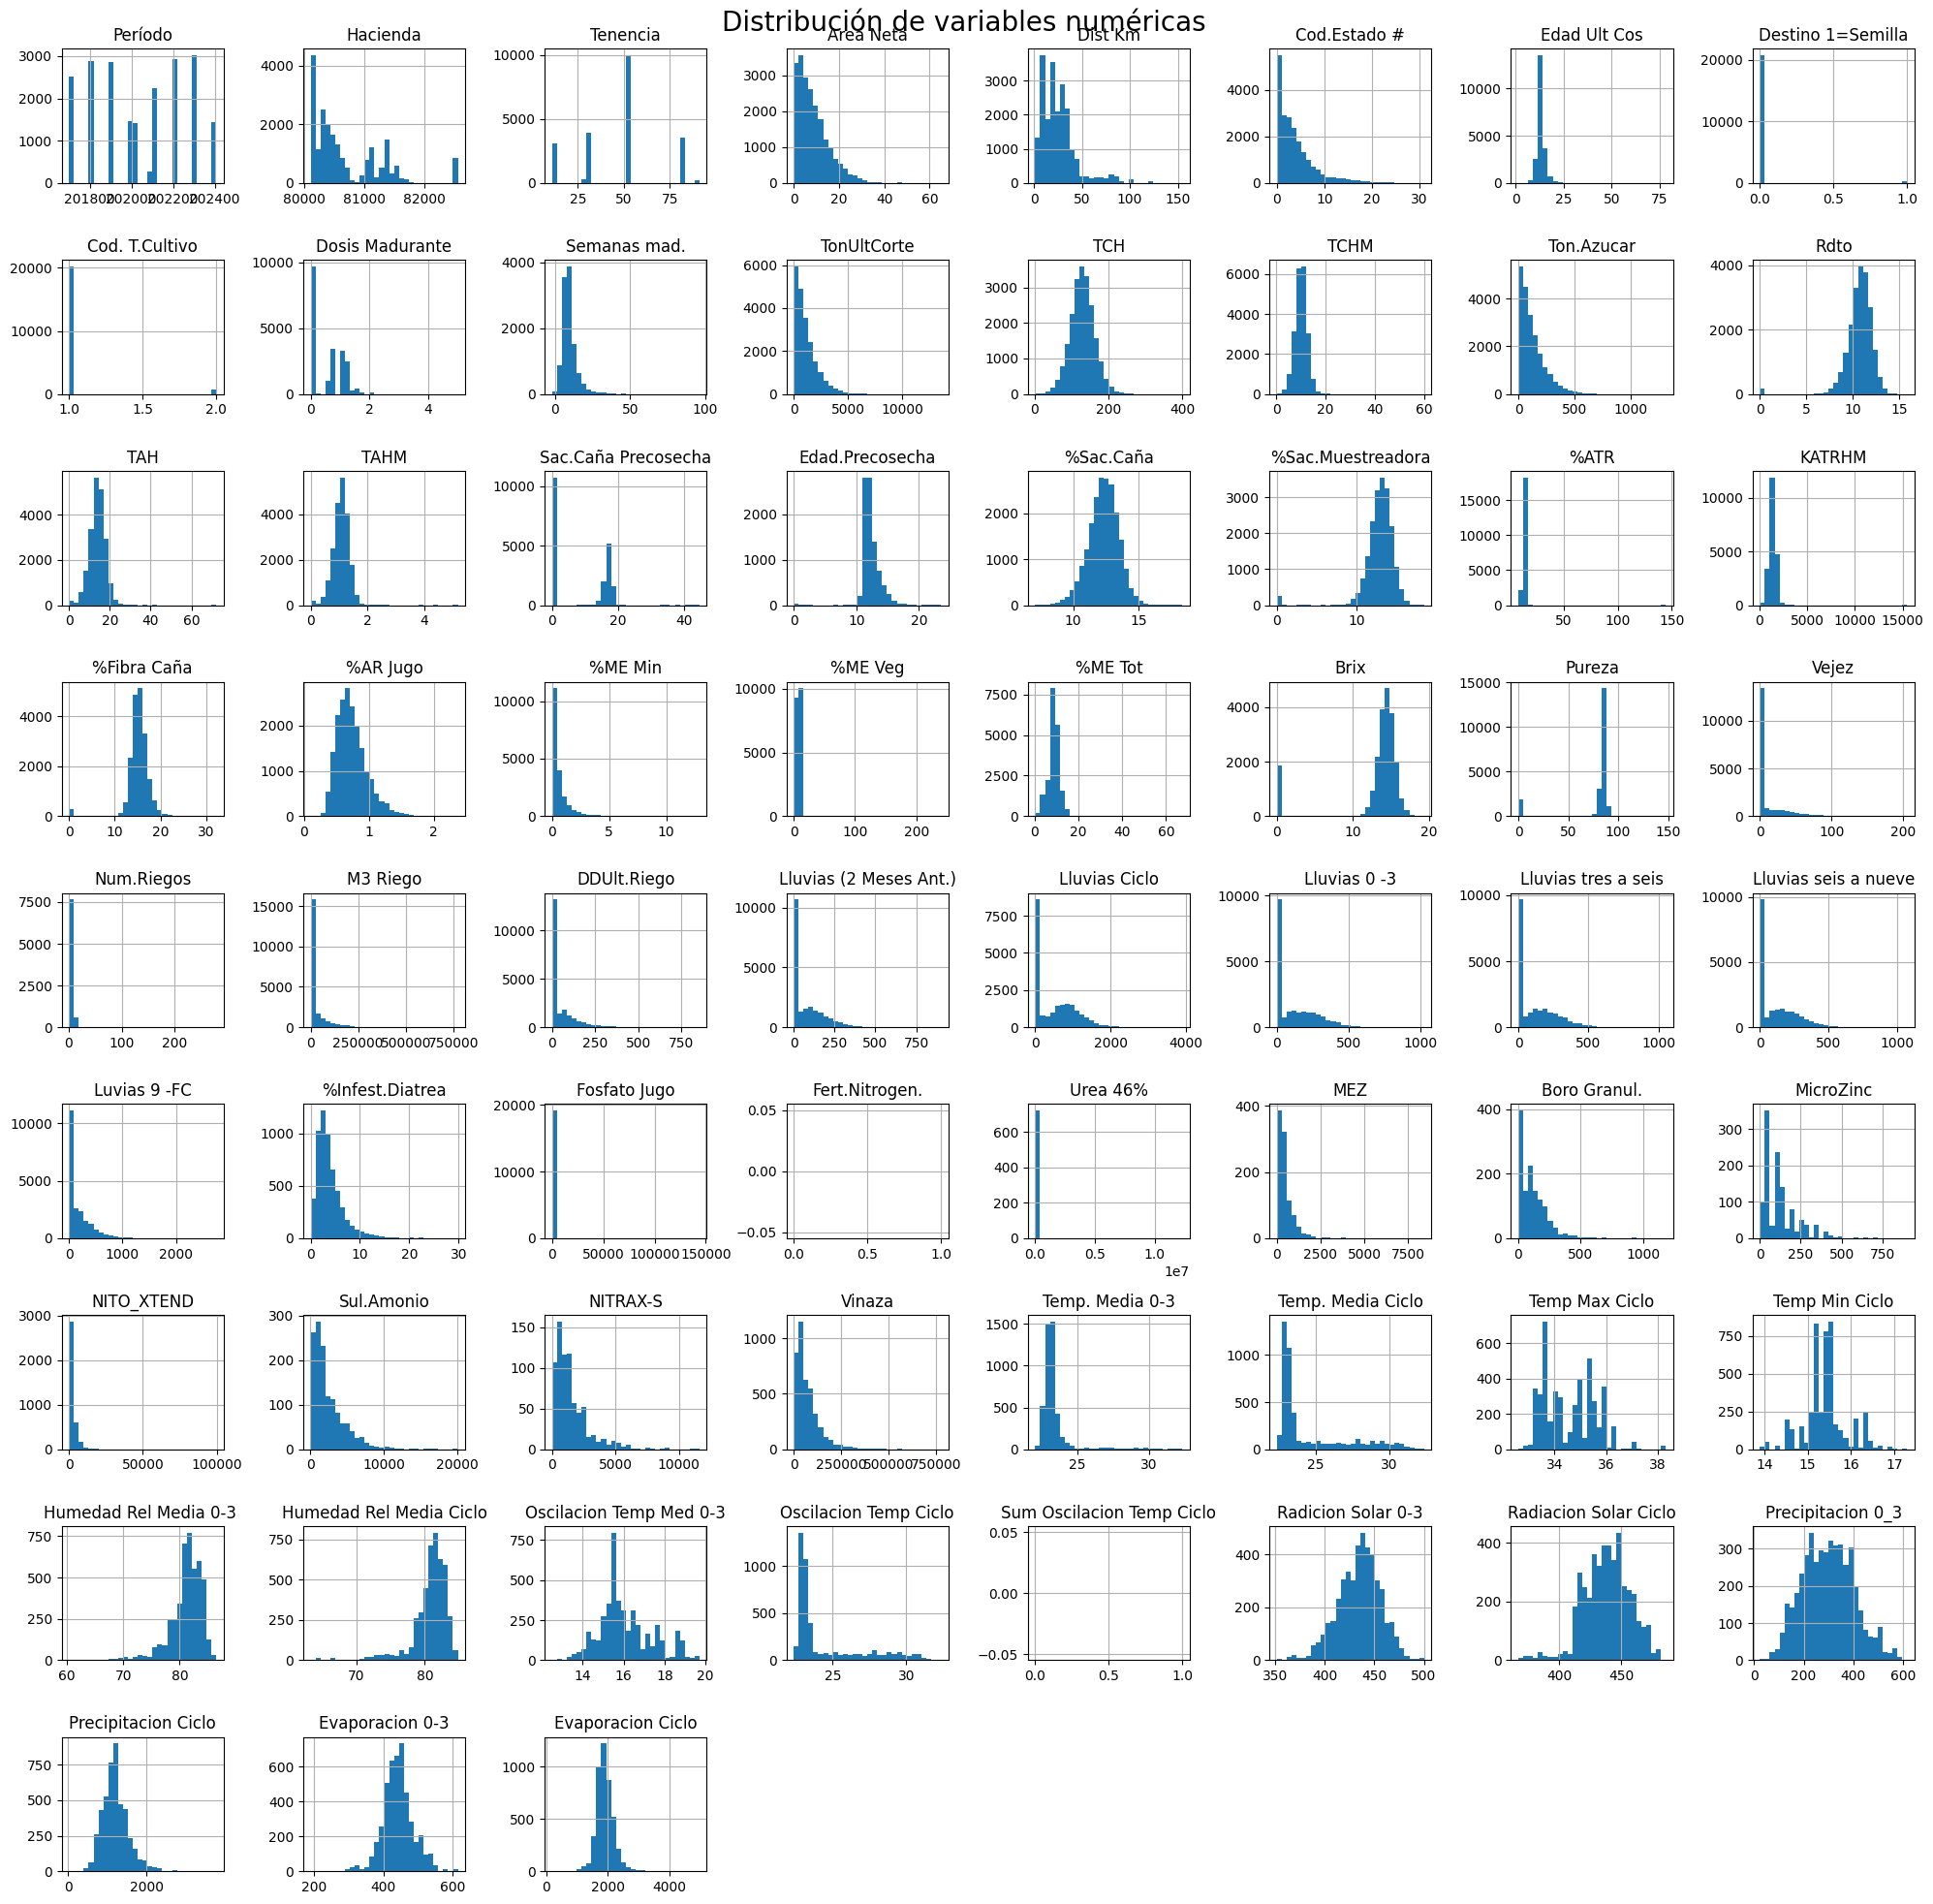

In [8]:
df[NUMERICAL_FEATURES].hist(
    bins=30,
    figsize=(20, 20),   
)
plt.suptitle("Distribución de variables numéricas", fontsize=20)
plt.tight_layout()
plt.show()

---
### **Limpieza: Identificadores** 

Limpieza de variables como `Periodo`, `Hacienda`, `Nombre`, `Suerte`, `Cod.Estado`, `F.Siembra` debido a posible data leakage o variables que no aportan prediccion porque pueden hacer las veces de identificadores más que de predictores. 

In [9]:
REDUNDANT_FEATURES = ['Período', 'Hacienda', 'Nombre', 'Suerte', 'Cod.Estado', 'F.Siembra', 'Cerca de', 'Tenencia', 'Zona', 'Cosechó']
df = df.drop(columns = REDUNDANT_FEATURES)

---
### **Matrices de Correlación**  
Matrices de correlación orientadas a TCH y %Sac.Caña, al igual que matriz de correlación general

In [10]:
NUMERICAL_FEATURES = df.select_dtypes(include=["int64", "float64"]).columns

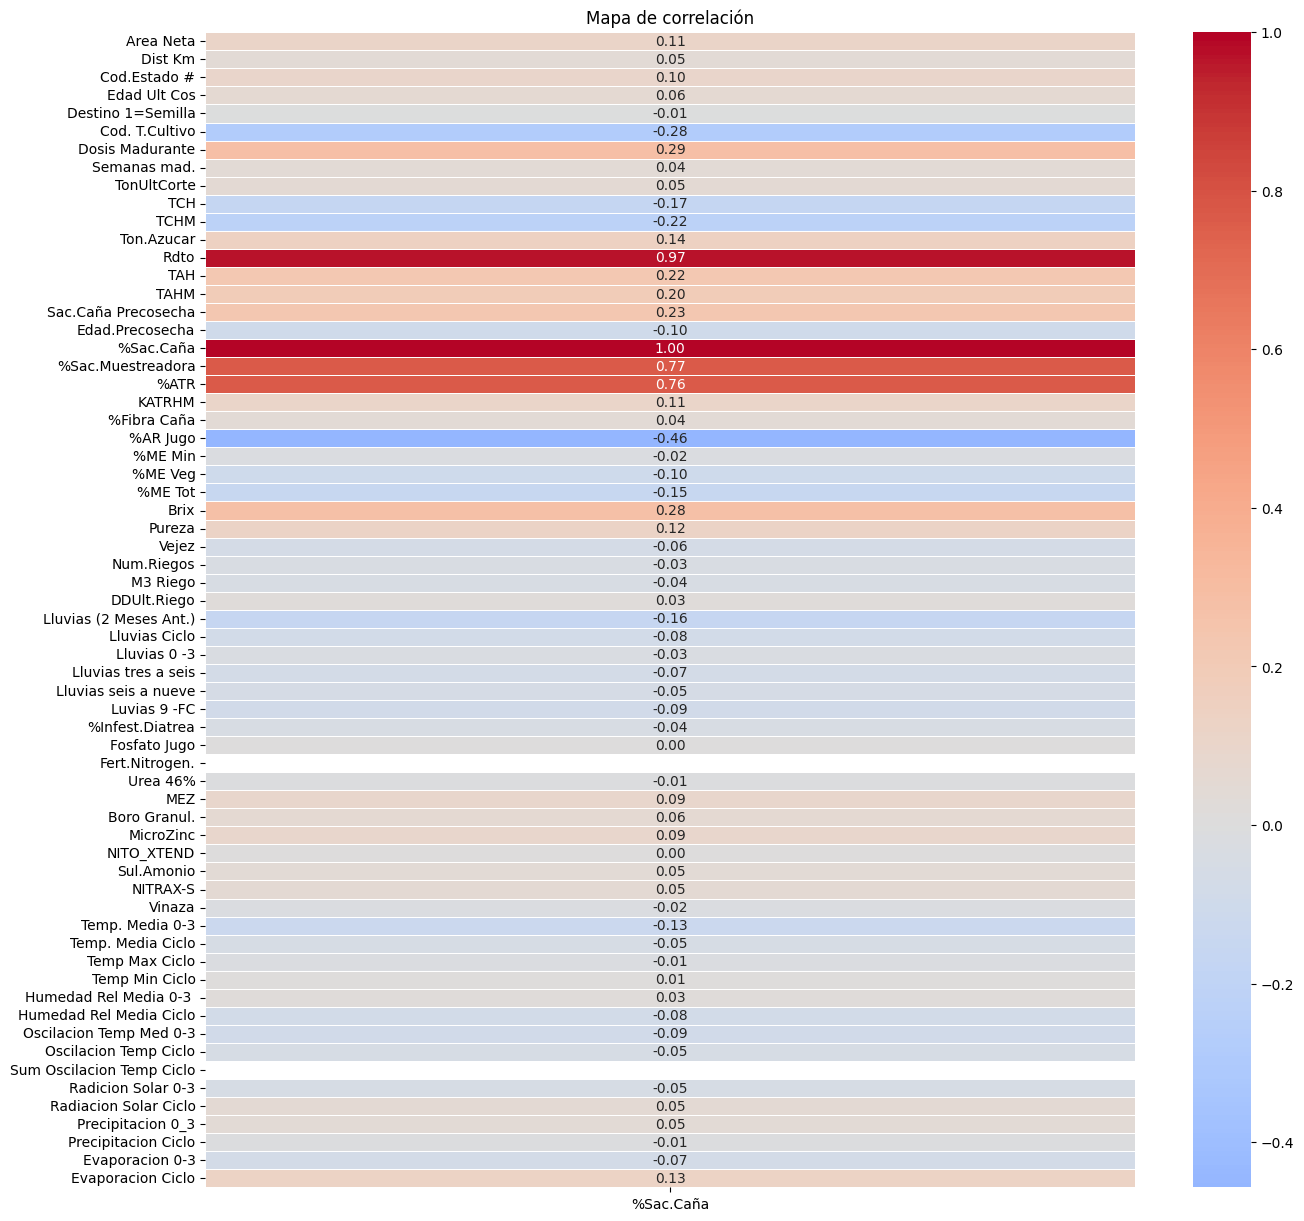

In [11]:
plt.figure(figsize=(15,15))
numerical_df = df[NUMERICAL_FEATURES]
numerical_corr = numerical_df.corr()
sns.heatmap(numerical_corr[["%Sac.Caña"]], 
            annot=True,
            cmap="coolwarm", 
            center=0,        
            fmt=".2f",       
            linewidths=0.5)  

plt.title("Mapa de correlación")
plt.show()

Se observa multicolinealidad entre algunas variables al igual que altas correlaciones entre variable objetivo y posibles leaks. 

---
### **Limpieza: Leakage para %Sac.Caña**
Se eliminan variables que se obtienen despues de la cosecha de la caña y que no influyen en la predicción de porcentaje de sacarosa.  

In [12]:
SAC_LEAKAGE = ['TonUltCorte', 'Ton.Azucar', 'Rdto', 'TAH', 'TAHM', 'Sac.Caña Precosecha', '%Sac.Muestreadora', '%ATR', 'KATRHM', '%Fibra Caña', '%AR Jugo', '%ME Min', '%ME Veg', '%ME Tot', 'Brix', 'Pureza', 'TCHM', 'TCH']

df = df.drop(columns = SAC_LEAKAGE)

---
### **Limpieza: Variables de Riego**  
Se revisan features relacionadas con riego y se observan correlaciones menores a 0.9, por el momento se decide dejarlas todas. 

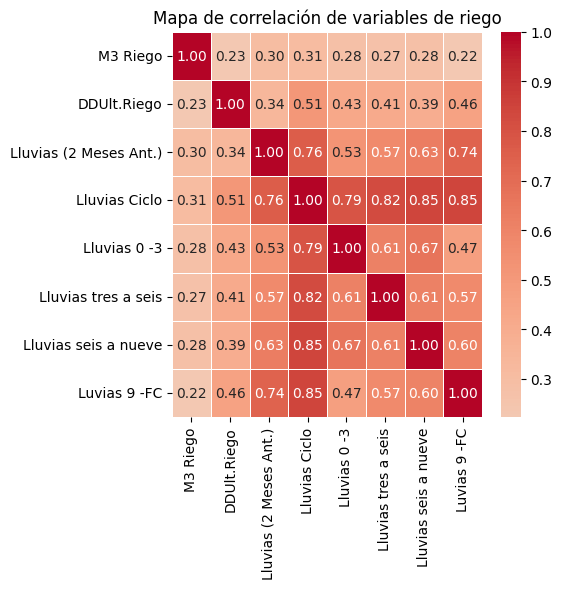

In [13]:
IRRIGATION_FEATURES = ['M3 Riego', 'DDUlt.Riego', 'Lluvias (2 Meses Ant.)', 'Lluvias Ciclo', 'Lluvias 0 -3', 'Lluvias tres a seis', 'Lluvias seis a nueve', 'Luvias 9 -FC']

plt.figure(figsize=(5,5))
numerical_irrig_df = df[IRRIGATION_FEATURES]
irrig_corr = numerical_irrig_df.corr()
sns.heatmap(irrig_corr, 
            annot=True,
            cmap="coolwarm", 
            center=0,        
            fmt=".2f",       
            linewidths=0.5)  

plt.title("Mapa de correlación de variables de riego")
plt.show()

Si bien están correlacionadas, cada una capturan diferentes aspectos. Se conservan para estudiar relaciones no lineales. 

---
### **Limpieza: Variables del clima**  
Se revisan variables relacionadas del clima. 

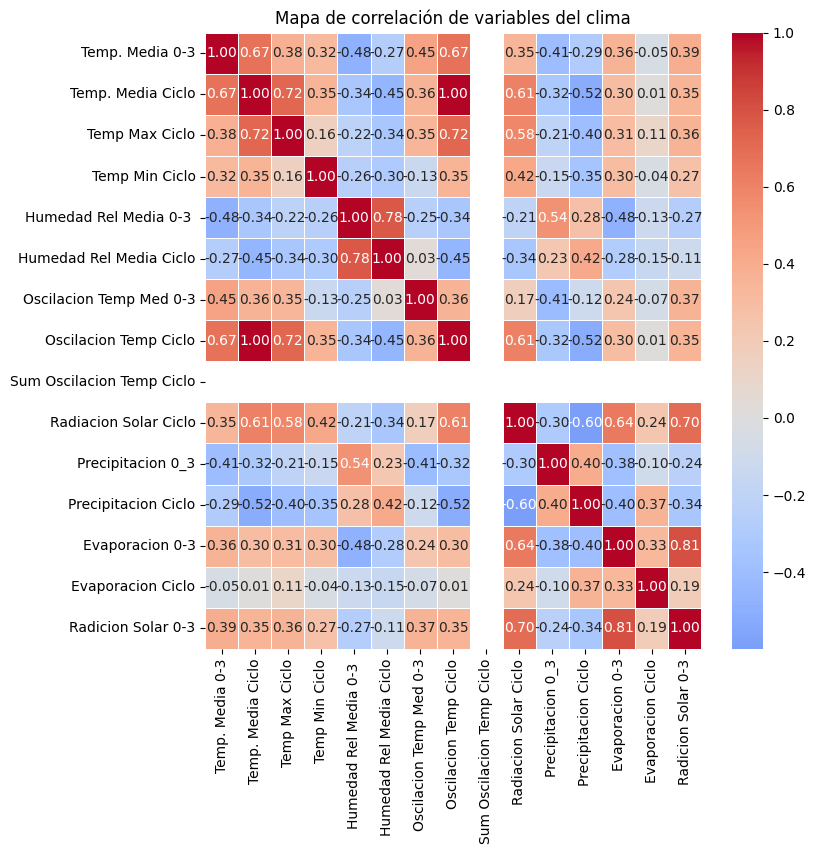

In [14]:
WEATHERING_FEATURES = ['Temp. Media 0-3', 'Temp. Media Ciclo', 'Temp Max Ciclo', 'Temp Min Ciclo', 'Humedad Rel Media 0-3 ', 'Humedad Rel Media Ciclo', 'Oscilacion Temp Med 0-3', 'Oscilacion Temp Ciclo', 'Sum Oscilacion Temp Ciclo', 'Radiacion Solar Ciclo', 'Precipitacion 0_3', 'Precipitacion Ciclo', 'Evaporacion 0-3', 'Evaporacion Ciclo', 'Radicion Solar 0-3']

plt.figure(figsize=(8,8))
numerical_weathering_df = df[WEATHERING_FEATURES]
weathering_corr = numerical_weathering_df.corr()
sns.heatmap(weathering_corr, 
            annot=True,
            cmap="coolwarm", 
            center=0,        
            fmt=".2f",       
            linewidths=0.5)  

plt.title("Mapa de correlación de variables del clima")
plt.show()

Se observa variable `Sum Oscilacion Temp Ciclo` vacía, se procede a eliminarla al igual que una de las variables `Oscilacion Temp Ciclo` debido a que tiene una correlación de 1 con `Temp Media Ciclo`. 

In [15]:
WEATHERING_DEPURE = ['Sum Oscilacion Temp Ciclo', 'Oscilacion Temp Ciclo']
WEATHERING_FEATURES = [f for f in WEATHERING_FEATURES if f not in WEATHERING_DEPURE]
df = df.drop(columns = WEATHERING_DEPURE)
df[WEATHERING_FEATURES]

Temp. Media 0-3  ...  Radicion Solar 0-3
0                  NaN  ...                 NaN
1                  NaN  ...                 NaN
2                  NaN  ...                 NaN
3                  NaN  ...                 NaN
4                  NaN  ...                 NaN
...                ...  ...                 ...
21022           30.930  ...             467.043
21023           30.348  ...             461.663
21024           30.348  ...             461.663
21025           30.731  ...             467.911
21026           30.113  ...             459.274

[21027 rows x 13 columns]

In [16]:
## Se elimina Fert. Nitrogen porque también está vacía
df = df.drop(columns = ['Fert.Nitrogen.'])

---
### **Distribucion Final**

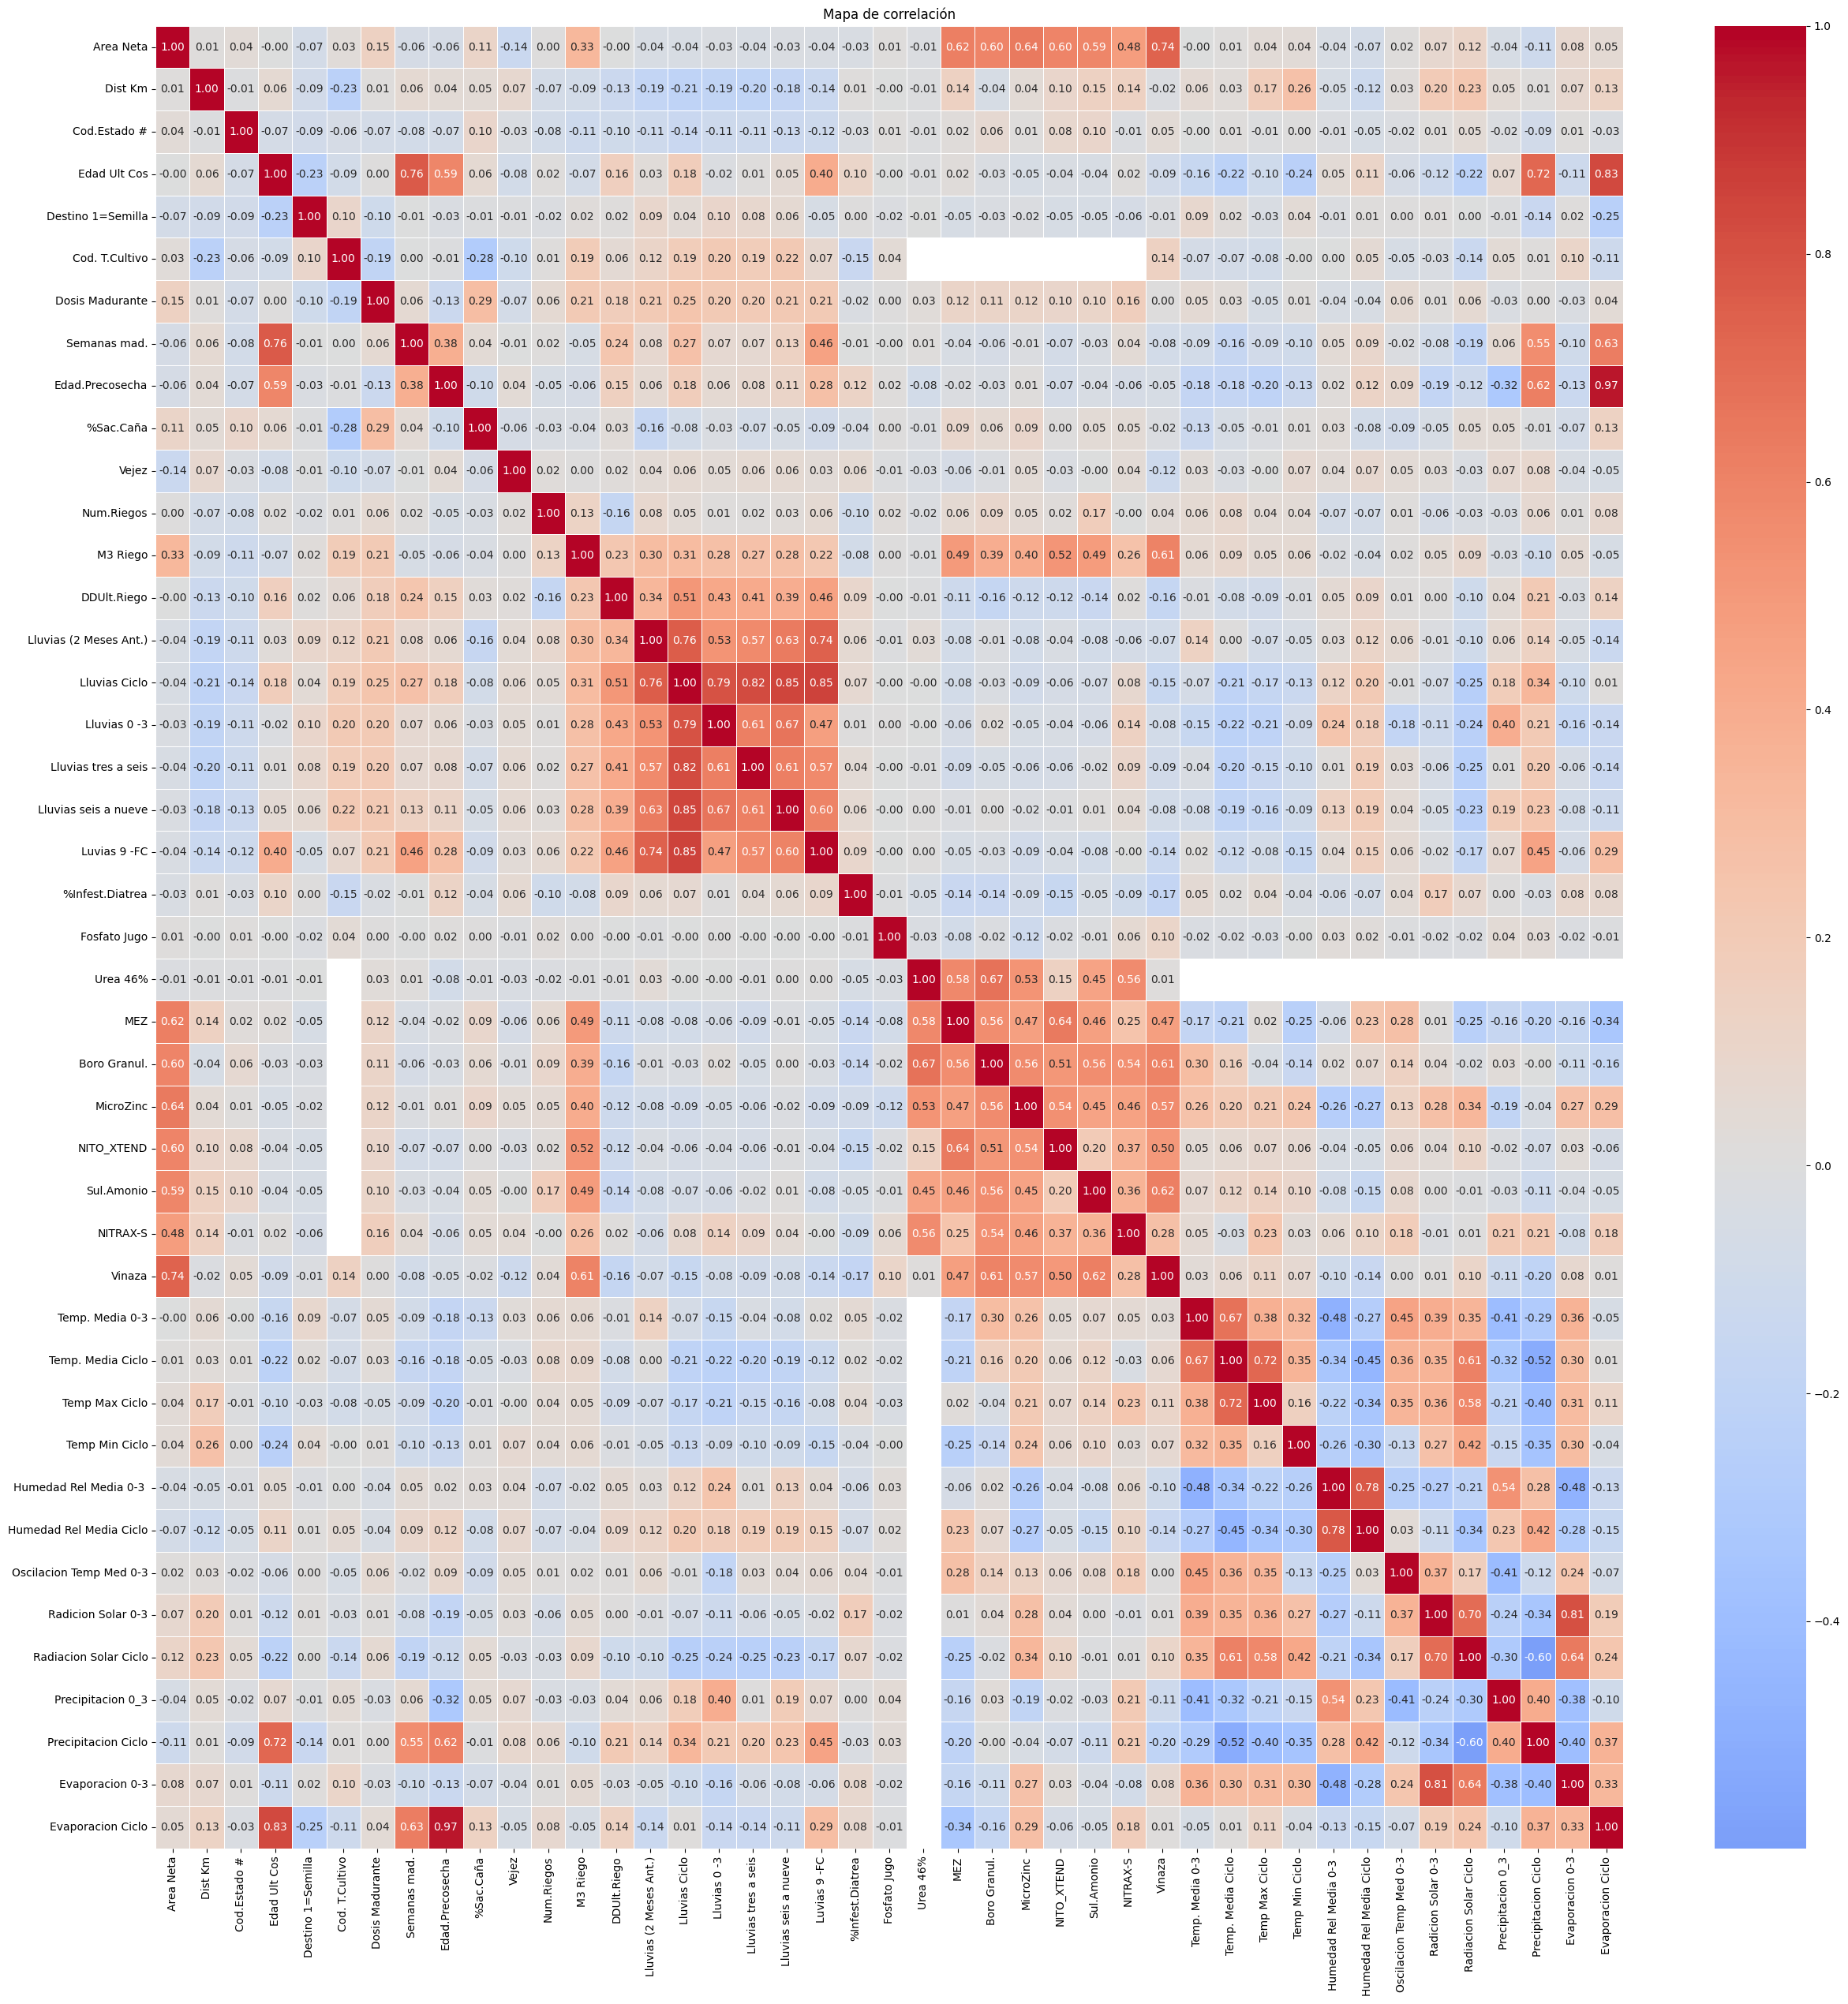

In [17]:
NUMERICAL_FEATURES = df.select_dtypes(include=["int64", "float64"]).columns
numerical_df = df[NUMERICAL_FEATURES]
numerical_corr = numerical_df.corr()
plt.figure(figsize=(30,30))
sns.heatmap(numerical_corr, 
            annot=True,
            cmap="coolwarm", 
            center=0,        
            fmt=".2f",       
            linewidths=0.5)  

plt.title("Mapa de correlación")
plt.show()

---
### **Distribución de %Sac.Caña**

In [18]:
df['%Sac.Caña'].describe()

count    20578.000000
mean        12.320202
std          1.145738
min          7.086000
25%         11.619000
50%         12.370650
75%         13.087500
max         18.400000
Name: %Sac.Caña, dtype: float64

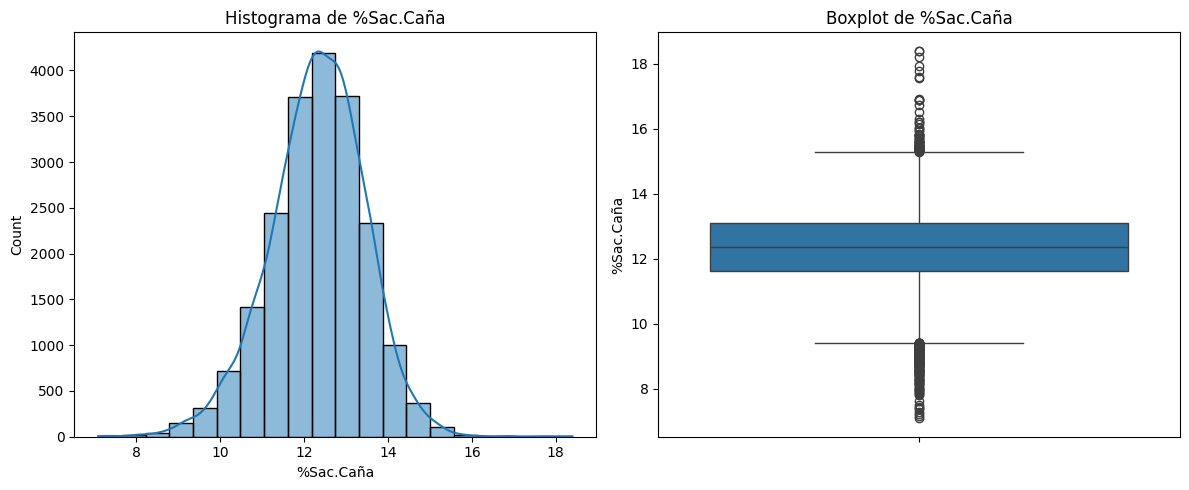

In [19]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['%Sac.Caña'], bins=20, kde=True, ax=axes[0])
axes[0].set_title("Histograma de %Sac.Caña")

sns.boxplot(y=df['%Sac.Caña'], ax=axes[1])
axes[1].set_title("Boxplot de %Sac.Caña")

plt.tight_layout()
plt.show()

Se decide no eliminar valores atipicos debido a que no parecen que sea por problemas de digitación, sino por condiciones naturales como el tipo de cultivo. 

### **Gráficos de Dispersión respecto a %Sac.Caña**  
Para revisar si se puede inferir alguna relación lineal, o cuadrática entre las variables predictoras y objetivo. 

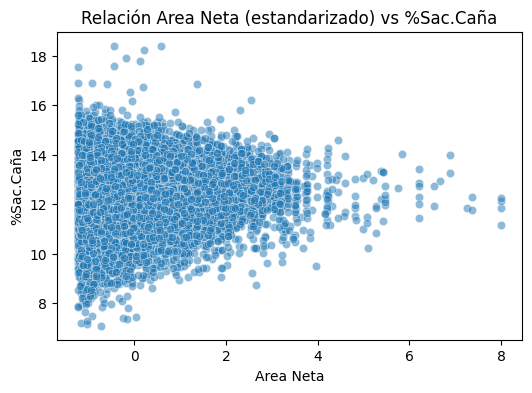

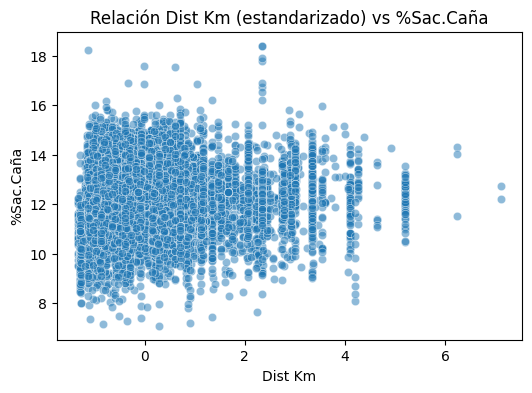

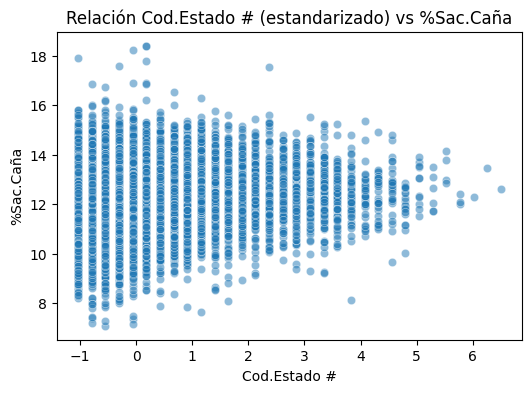

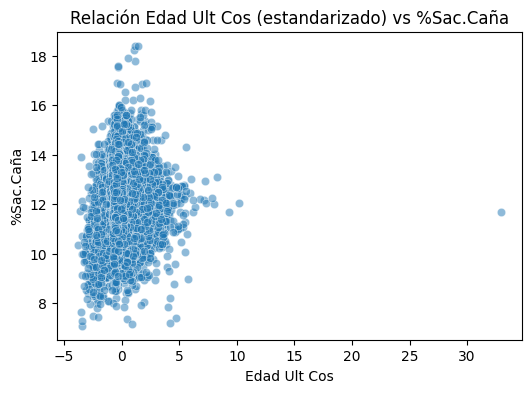

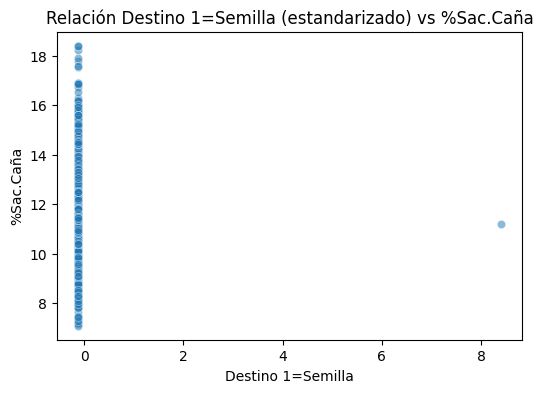

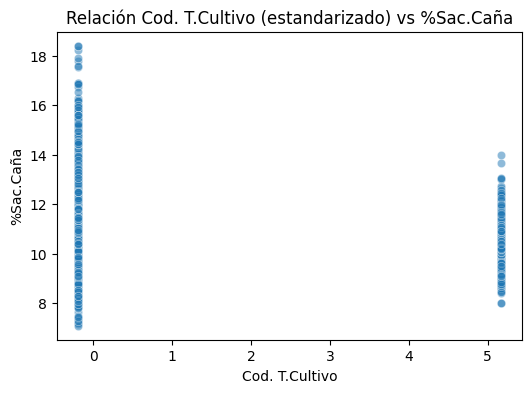

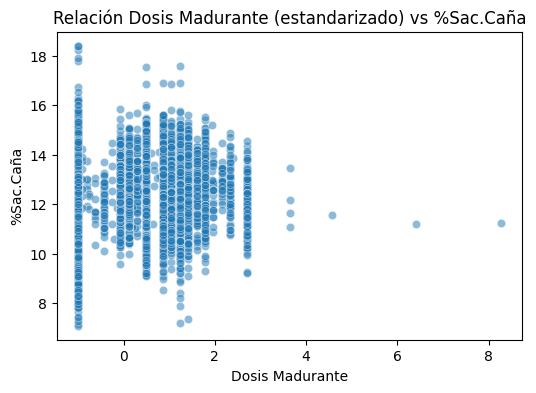

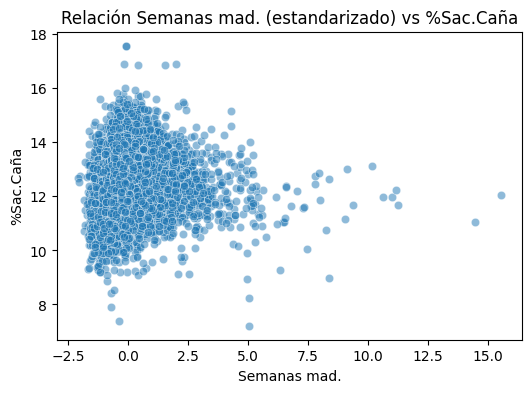

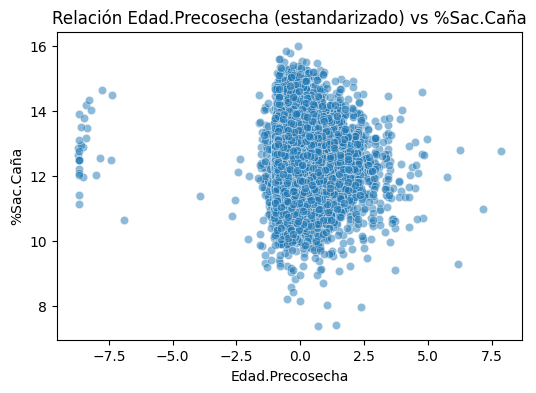

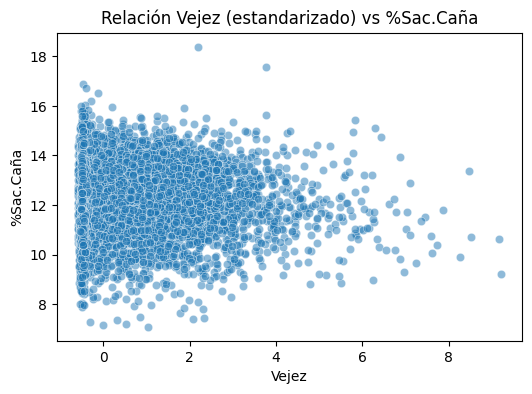

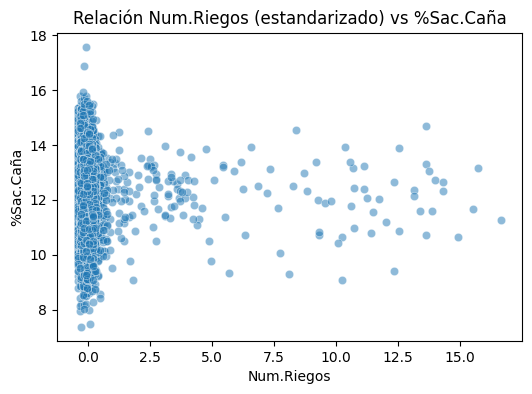

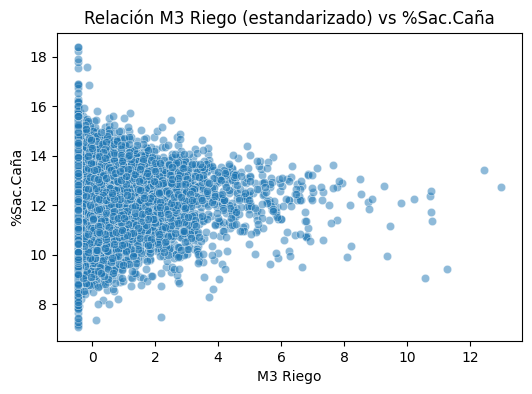

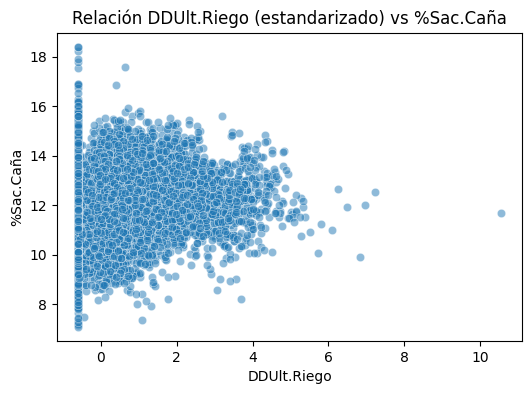

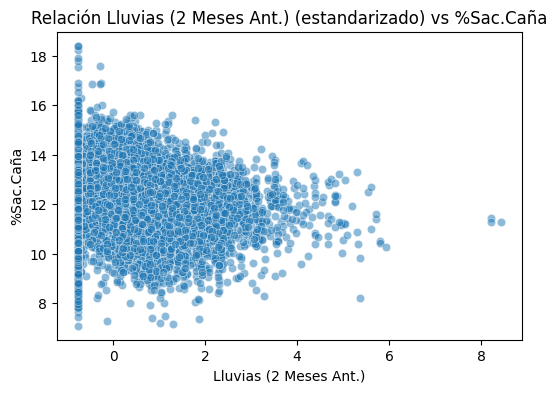

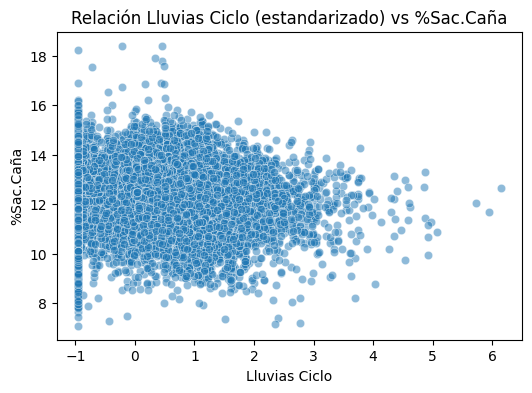

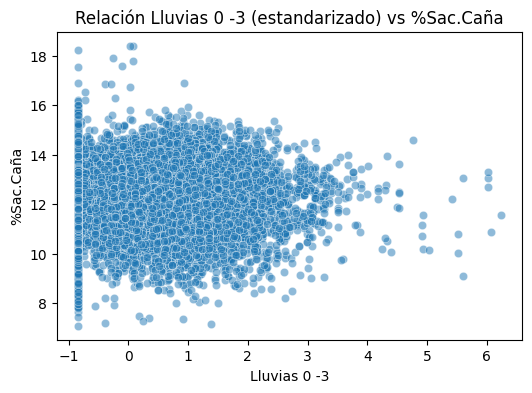

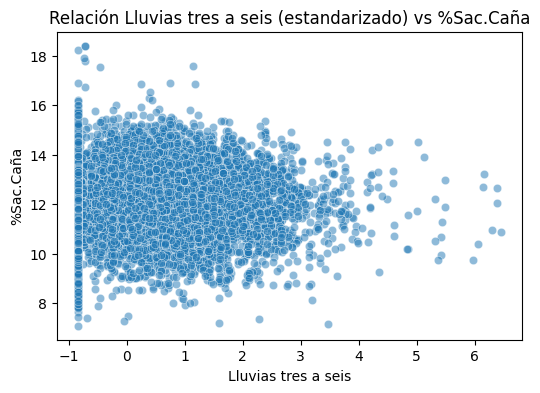

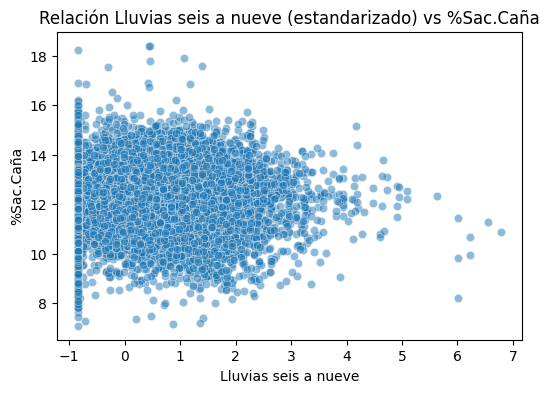

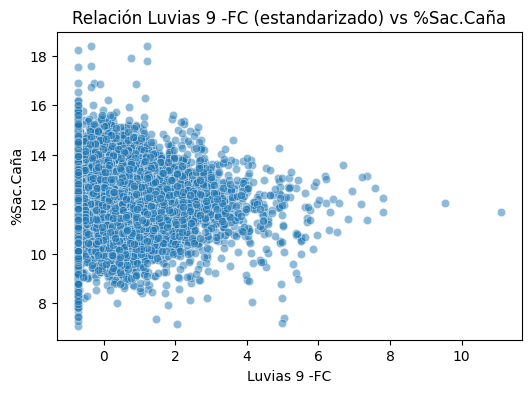

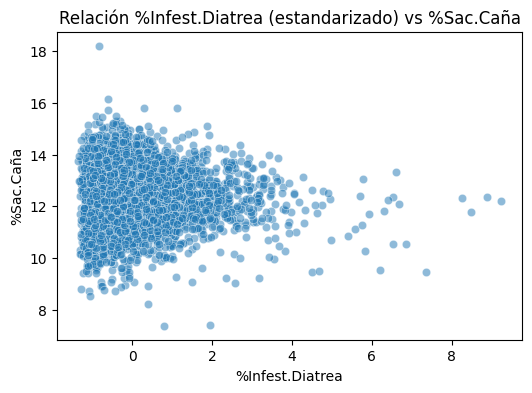

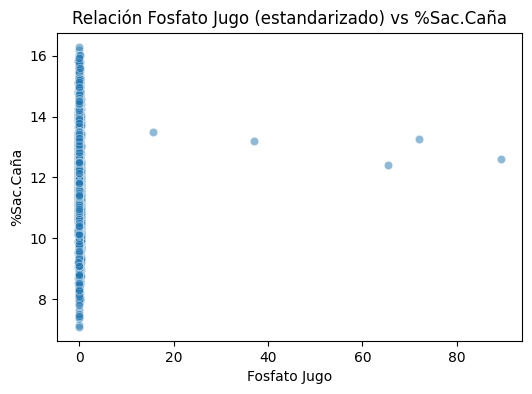

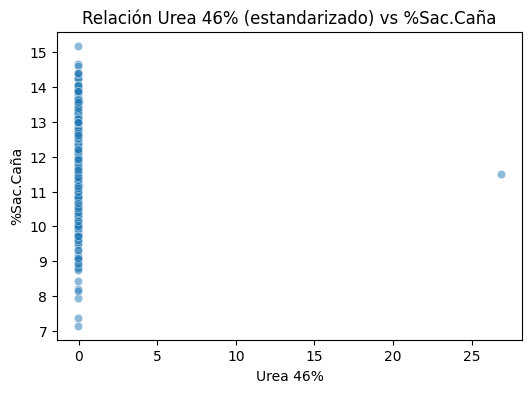

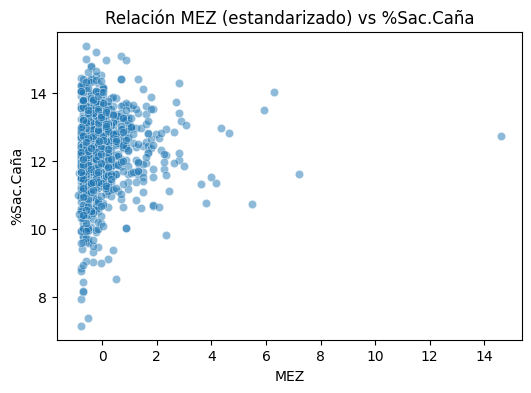

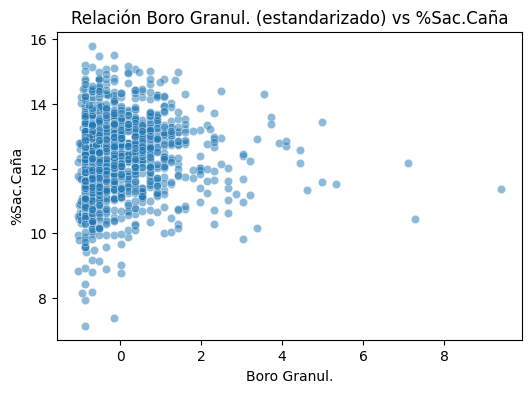

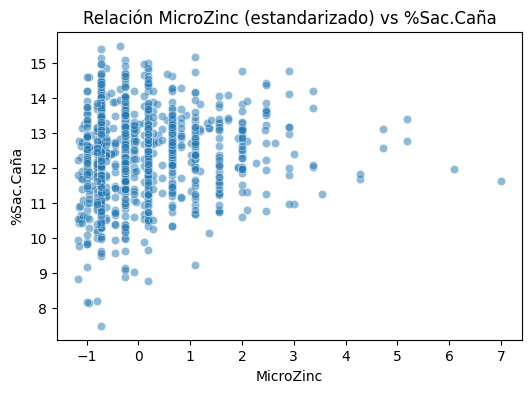

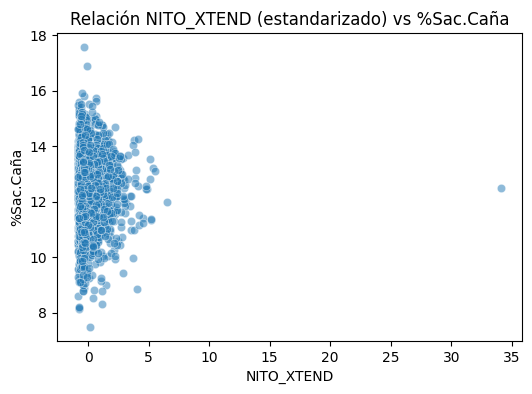

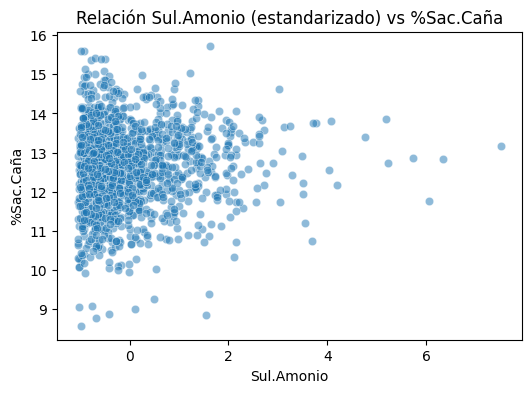

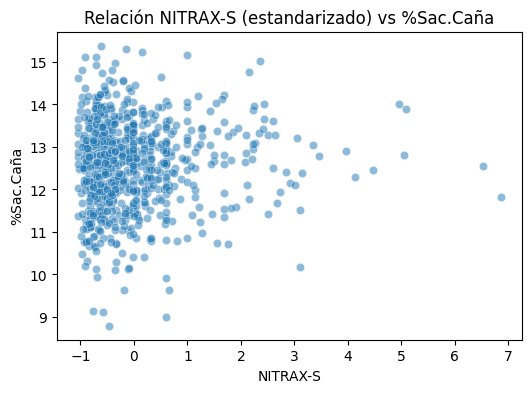

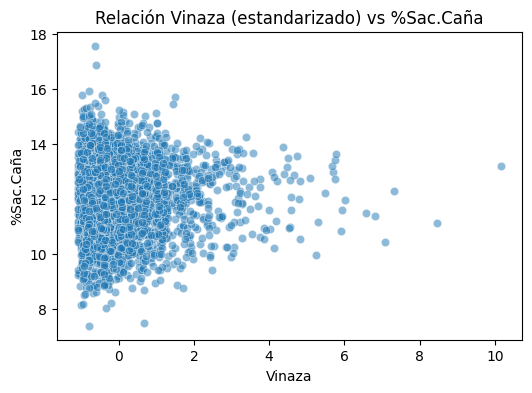

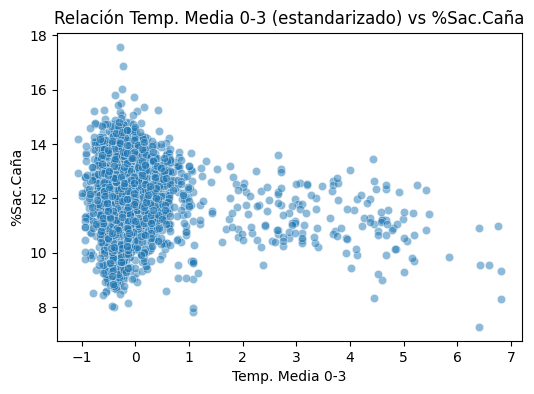

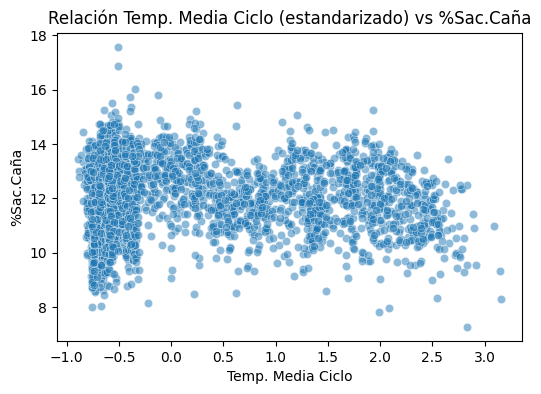

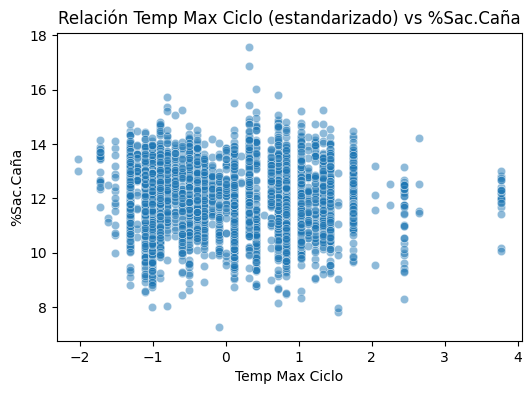

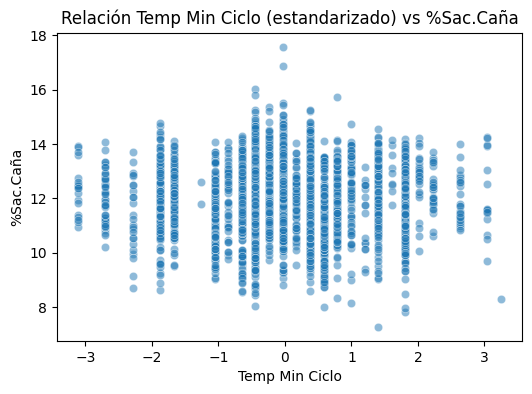

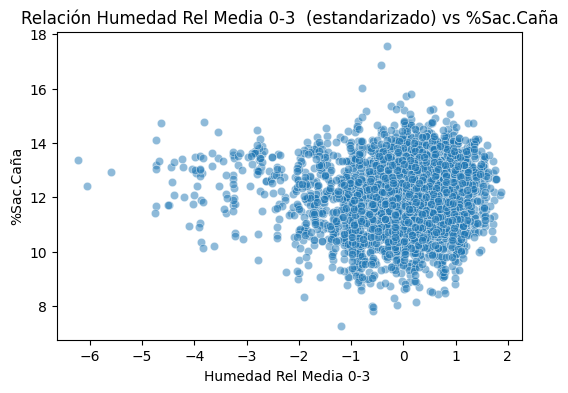

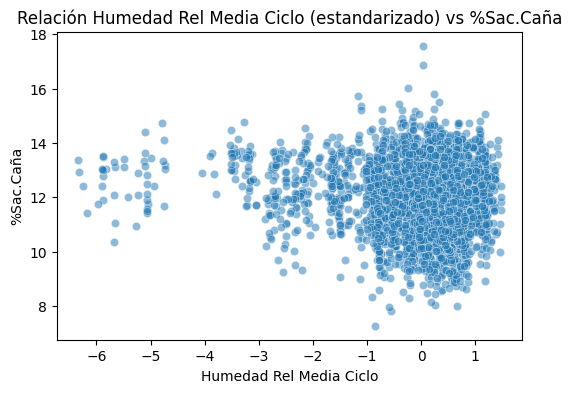

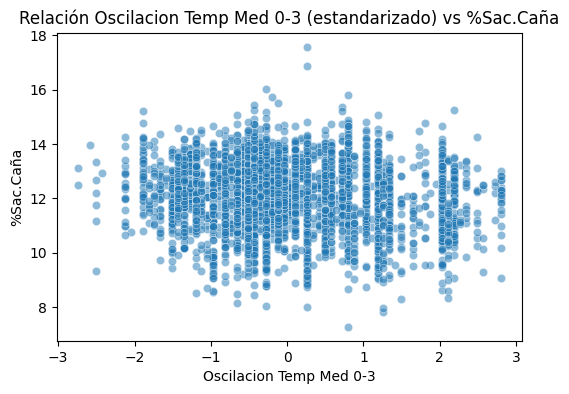

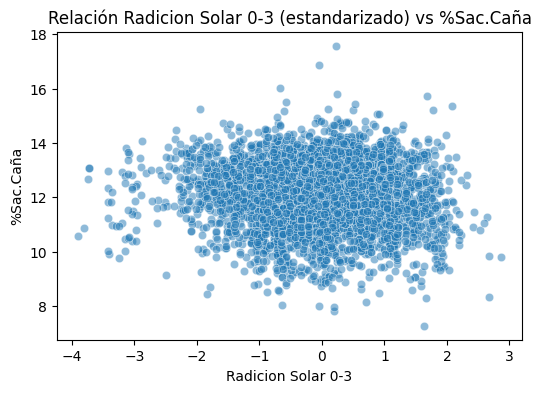

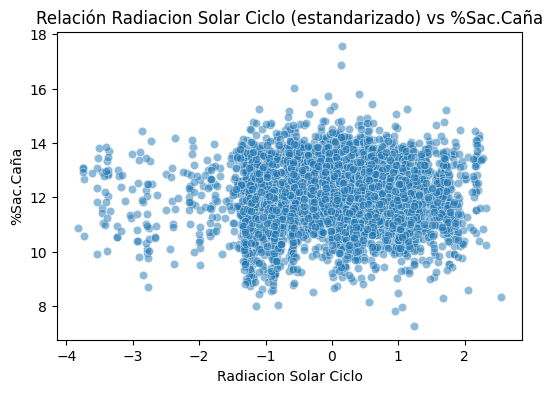

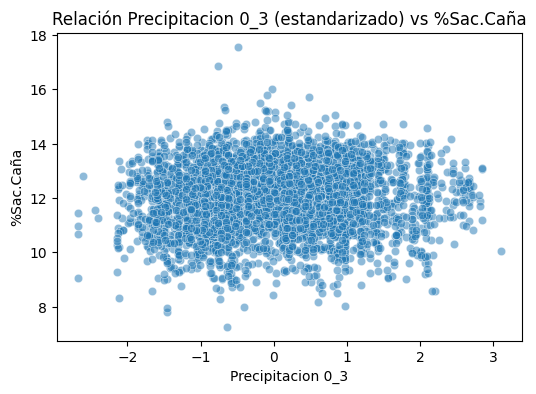

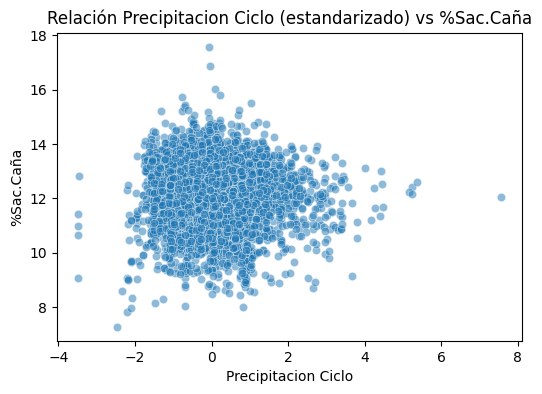

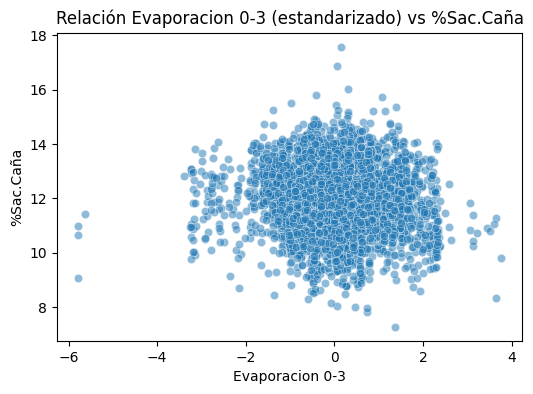

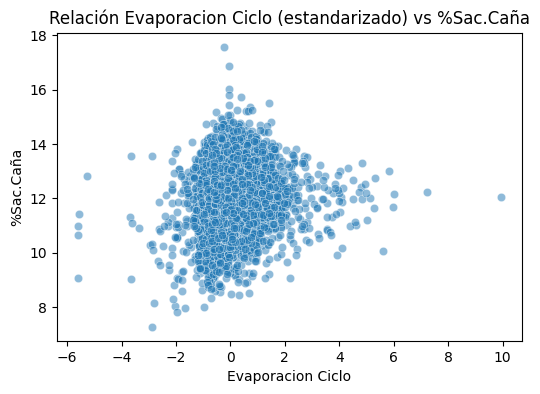

In [20]:
from sklearn.preprocessing import StandardScaler
df_filtered = df.copy()
numericas = df_filtered.select_dtypes(include='number').columns

numericas_sin_tch = [col for col in numericas if col != '%Sac.Caña']

scaler = StandardScaler()
df_scaled = df_filtered.copy()
df_scaled[numericas_sin_tch] = scaler.fit_transform(df_filtered[numericas_sin_tch])

for col in numericas_sin_tch:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df_scaled[col], y=df_scaled['%Sac.Caña'], alpha=0.5)
    plt.title(f"Relación {col} (estandarizado) vs %Sac.Caña")
    plt.show()

---
#### **Imputación de algunos valores nulos**

In [21]:
## Productos químicos, fertilizantes
CHEM_FEATURES = ['Urea 46%', 'NITRAX-S', 'MEZ', 'NITO_XTEND', 'Vinaza', 'MicroZinc', 'Boro Granul.', 'Sul.Amonio']
df[CHEM_FEATURES] = df[CHEM_FEATURES].fillna(0)

In [22]:
## trabajamos solo con los valores no nulos de %Sac.Caña, se elimina porque no es un alto porcentaje de nulos
df_mod = df.dropna(subset=['%Sac.Caña'])

In [23]:
df_mod['%Sac.Caña'].isnull().sum()

np.int64(0)

In [24]:
df_mod.loc[:, '%Infest.Diatrea'] = df_mod['%Infest.Diatrea'].fillna(0)

In [25]:
null_percent = df_mod[['Dosis Madurante', 'Vejez', 'Evaporacion Ciclo', 'Cod. T.Cultivo', 'Radiacion Solar Ciclo', 'Precipitacion Ciclo', 'Lluvias Ciclo', 'Humedad Rel Media Ciclo', 'Humedad Rel Media 0-3 ', 'Temp. Media 0-3', 'Area Neta', 'M3 Riego',  'DDUlt.Riego', 'Lluvias (2 Meses Ant.)', 'Lluvias 0 -3', 'Lluvias seis a nueve', 'Luvias 9 -FC', '%Infest.Diatrea', 'Vinaza', 'Oscilacion Temp Med 0-3', 'Evaporacion 0-3', 'Temp. Media Ciclo', 'Temp Max Ciclo', 'Temp Min Ciclo', 'Fosfato Jugo', 'Destino 1=Semilla']].isnull().mean() * 100
null_percent.sort_values(ascending=False).head(10)

Radiacion Solar Ciclo      78.74915
Evaporacion Ciclo          78.74915
Temp. Media 0-3            78.74915
Humedad Rel Media 0-3      78.74915
Precipitacion Ciclo        78.74915
Humedad Rel Media Ciclo    78.74915
Temp Min Ciclo             78.74915
Evaporacion 0-3            78.74915
Temp. Media Ciclo          78.74915
Temp Max Ciclo             78.74915
dtype: float64

In [26]:
df_mod = df_mod.dropna(subset=['Evaporacion Ciclo'])

In [27]:
df_mod['Evaporacion Ciclo'].isnull().sum()

np.int64(0)

In [28]:
null_percent = df_mod[['Dosis Madurante', 'Vejez', 'Evaporacion Ciclo', 'Cod. T.Cultivo', 'Radiacion Solar Ciclo', 'Precipitacion Ciclo', 'Lluvias Ciclo', 'Humedad Rel Media Ciclo', 'Humedad Rel Media 0-3 ', 'Temp. Media 0-3', 'Area Neta', 'M3 Riego',  'DDUlt.Riego', 'Lluvias (2 Meses Ant.)', 'Lluvias 0 -3', 'Lluvias seis a nueve', 'Luvias 9 -FC', '%Infest.Diatrea', 'Vinaza', 'Oscilacion Temp Med 0-3', 'Evaporacion 0-3', 'Temp. Media Ciclo', 'Temp Max Ciclo', 'Temp Min Ciclo', 'Fosfato Jugo', 'Destino 1=Semilla']].isnull().mean() * 100
null_percent.sort_values(ascending=False).head(10)

Fosfato Jugo               5.122342
Vejez                      4.001829
Dosis Madurante            0.182941
Evaporacion Ciclo          0.000000
Radiacion Solar Ciclo      0.000000
Cod. T.Cultivo             0.000000
Lluvias Ciclo              0.000000
Humedad Rel Media Ciclo    0.000000
Humedad Rel Media 0-3      0.000000
Precipitacion Ciclo        0.000000
dtype: float64

#### **Revisión de variables categóricas respecto a target**

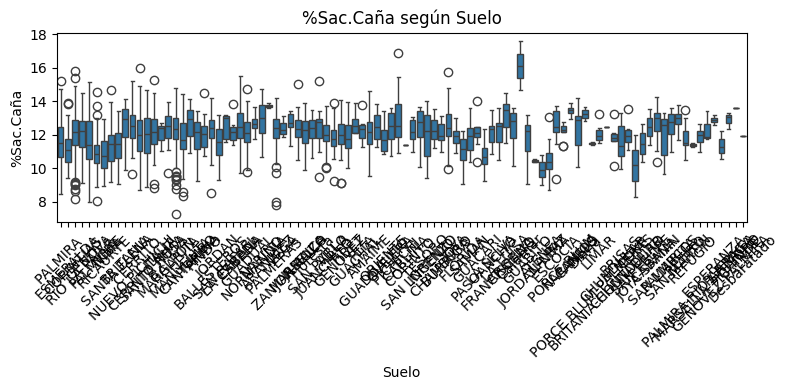

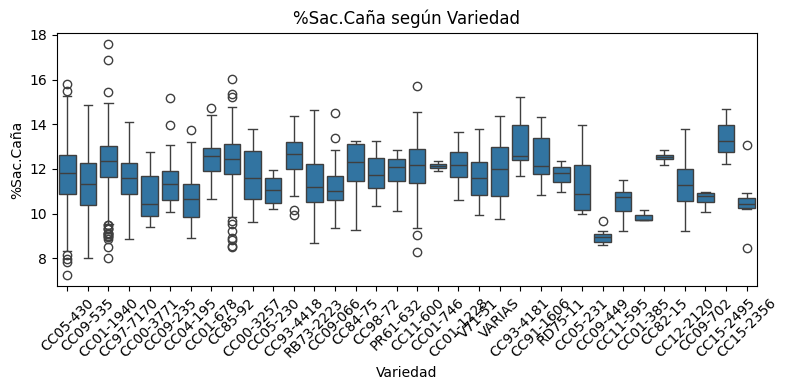

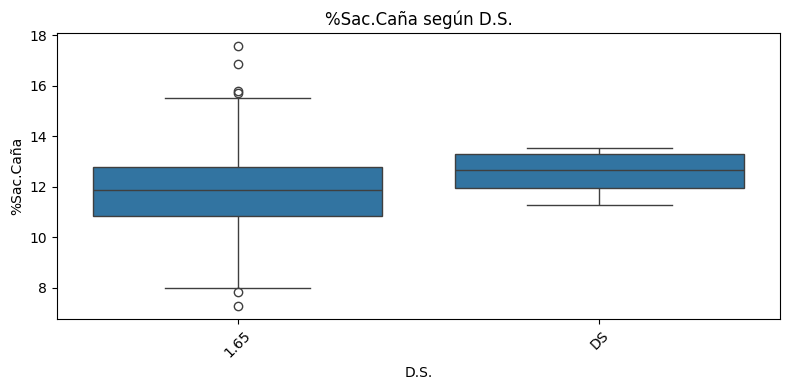

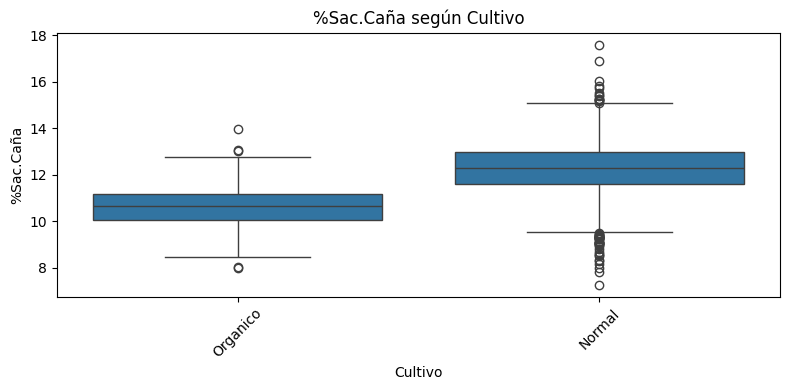

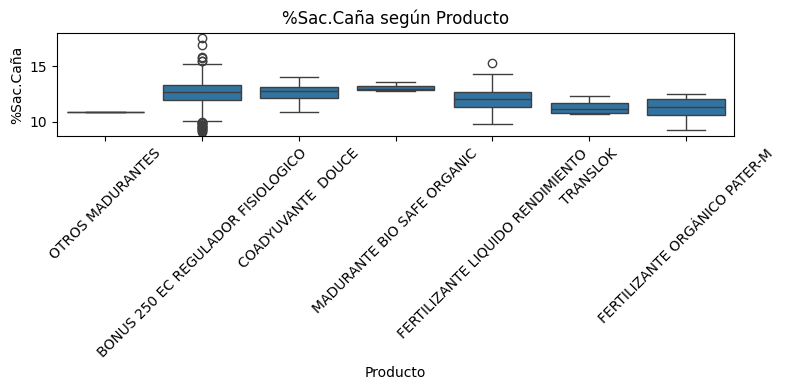

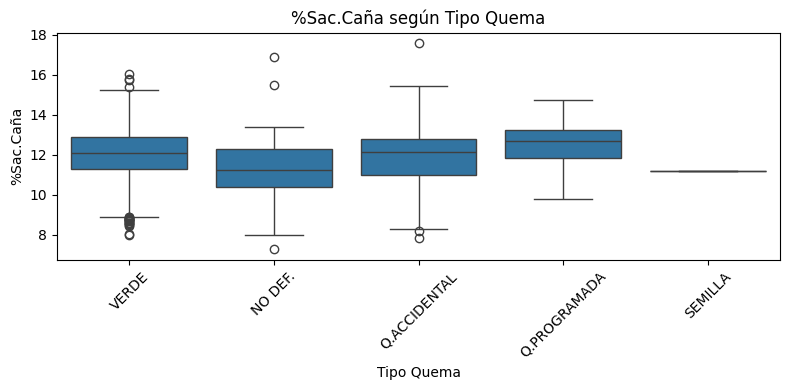

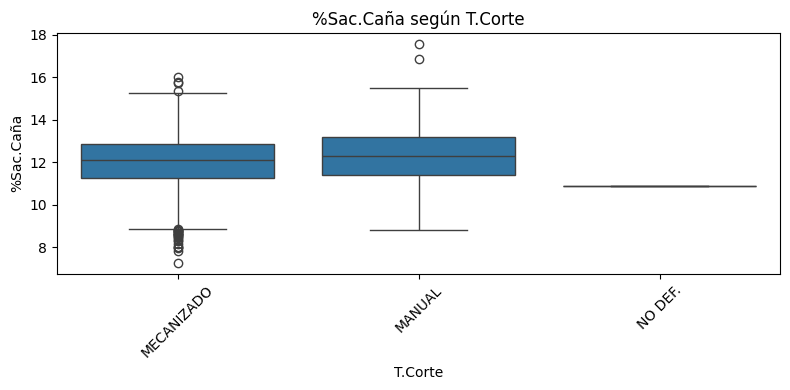

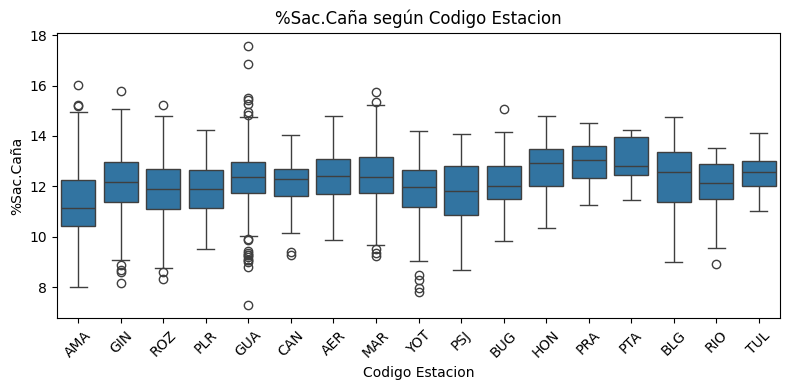

                     F_value        p_value
Cultivo          1267.938655  4.496071e-244
Producto         1168.216360  4.001717e-227
D.S.              142.098939   2.911535e-32
Variedad           27.075584   2.046182e-07
Suelo              23.561514   1.252029e-06
Tipo Quema          7.392599   6.575143e-03
T.Corte             6.567582   1.041850e-02
Codigo Estacion     1.716251   1.902452e-01


In [29]:
from sklearn.feature_selection import f_classif, f_regression
from sklearn.preprocessing import LabelEncoder

cat_features = df_mod.select_dtypes(include=['object', 'category']).columns.tolist()

for col in cat_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df_mod[col], y=df_mod['%Sac.Caña'])
    plt.title(f"%Sac.Caña según {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


anova_results = {}
for col in cat_features:
    le = LabelEncoder()
    x = le.fit_transform(df_mod[col].astype(str))
    f_val, p_val = f_regression(x.reshape(-1, 1), df_mod['%Sac.Caña'])
    anova_results[col] = (f_val[0], p_val[0])

anova_df = pd.DataFrame(anova_results, index=['F_value', 'p_value']).T
print(anova_df.sort_values('F_value', ascending=False))

In [30]:
## Variedad desbalanceada
df_mod['Variedad'].value_counts()

Variedad
CC01-1940    1981
CC05-430     1035
CC85-92       407
CC09-535      114
RB73-2223     100
CC09-066       94
CC93-4418      76
CC04-195       73
CC97-7170      70
CC11-600       68
VARIAS         50
CC01-1228      46
CC98-72        36
V71-51         34
CC01-678       30
CC00-3257      27
PR61-632       20
CC12-2120      14
CC93-4181      13
CC09-235       13
CC84-75        10
CC09-449        8
CC15-2356       7
CC00-3771       6
CC05-230        6
CC91-1606       6
CC11-595        5
CC09-702        4
RD75-11         4
CC05-231        4
CC82-15         4
CC01-385        3
CC15-2495       3
CC01-746        2
Name: count, dtype: int64

In [31]:
def reagrupar_por_frecuencia(df, umbral=50, categoria='Variedad'):
    df_copy = df.copy()
    
    counts = df_copy[categoria].value_counts()
    variedades_frecuentes = counts[counts >= umbral].index.tolist()
    nuevaCol = categoria + '_Reagrupada'
    df_copy[nuevaCol] = df_copy[categoria].apply(
        lambda x: x if x in variedades_frecuentes else 'OTRAS'
    )
    
    return df_copy

df_mod = reagrupar_por_frecuencia(df_mod, umbral=400, categoria="Variedad")
print(df_mod['Variedad_Reagrupada'].value_counts())

Variedad_Reagrupada
CC01-1940    1981
CC05-430     1035
OTRAS         950
CC85-92       407
Name: count, dtype: int64


In [32]:
## Suelo desbalanceada
df_mod['Suelo'].value_counts()

Suelo
CORINTIAS             1018
GALPON                 543
PALMIRA                430
MANUELITA              167
NUEVO PICHICHI         125
                      ... 
JOYA-SAMAN               2
CARLINA                  1
BRITANIA-CHUNDULAR       1
PICHINDE                 1
Desbaratado              1
Name: count, Length: 96, dtype: int64

In [33]:
df_mod['Suelo'] = df_mod['Suelo'].fillna(df_mod['Suelo'].mode()[0])

In [34]:
df_mod = reagrupar_por_frecuencia(df_mod, umbral=80, categoria="Suelo")
print(df_mod['Suelo_Reagrupada'].value_counts())

Suelo_Reagrupada
OTRAS             1423
CORINTIAS         1219
GALPON             543
PALMIRA            430
MANUELITA          167
NUEVO PICHICHI     125
PALMERAS           100
GENOVA              97
CERRITO             92
SANTA ROSA          90
PALMICHE            87
Name: count, dtype: int64


--- 
#### **Evaluación y preprocesamiento General**

In [35]:
from sklearn.model_selection import train_test_split

X = df_mod[['Dosis Madurante', 'Vejez', 'Evaporacion Ciclo', 'Cod. T.Cultivo', 'Radiacion Solar Ciclo', 'Precipitacion Ciclo', 'Lluvias Ciclo', 'Humedad Rel Media Ciclo', 'Humedad Rel Media 0-3 ', 'Temp. Media 0-3', 'Area Neta', 'M3 Riego',  'DDUlt.Riego', 'Lluvias (2 Meses Ant.)', 'Lluvias 0 -3', 'Lluvias seis a nueve', 'Luvias 9 -FC', '%Infest.Diatrea', 'Vinaza', 'Oscilacion Temp Med 0-3', 'Evaporacion 0-3', 'Temp. Media Ciclo', 'Temp Max Ciclo', 'Temp Min Ciclo', 'Fosfato Jugo', 'Variedad_Reagrupada', 'Destino 1=Semilla']]
y = df_mod['%Sac.Caña']

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=None
)


#### **Regresión Lineal**

In [36]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),   
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

cv_scores_lr_mse = -cross_val_score(
    LinearRegression(),
    X_train_prep, y_train,
    cv=5,
    scoring='neg_mean_squared_error'
)

cv_scores_lr_r2 = cross_val_score(
    LinearRegression(),
    X_train_prep, y_train,
    cv=5,
    scoring='r2'
)

cv_scores_lr_rmse = np.sqrt(cv_scores_lr_mse)
print("\n--- Regresión Lineal Múltiple (Validación Cruzada) ---")
print(f"MSE promedio: {np.mean(cv_scores_lr_mse):.4f} (+/- {np.std(cv_scores_lr_mse):.4f})")
print(f"RMSE promedio: {np.mean(cv_scores_lr_rmse):.4f} (+/- {np.std(cv_scores_lr_rmse):.4f})")
print(f"R^2 promedio: {np.mean(cv_scores_lr_r2):.4f} (+/- {np.std(cv_scores_lr_r2):.4f})")

# --- Ridge y Lasso con GridSearch ---
param_grid = {'alpha': np.logspace(-4, 2, 100)}  

grid_search_ridge = GridSearchCV(
    Ridge(),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_ridge.fit(X_train_prep, y_train)

grid_search_lasso = GridSearchCV(
    Lasso(max_iter=5000),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_lasso.fit(X_train_prep, y_train)

# --- Ridge ---
ridge_best = grid_search_ridge.best_estimator_
y_pred_ridge = ridge_best.predict(X_test_prep)

ridge_mse_test = mean_squared_error(y_test, y_pred_ridge)
ridge_rmse_test = np.sqrt(ridge_mse_test)
ridge_r2_test = r2_score(y_test, y_pred_ridge)

print("\n--- Ridge (L2) ---")
print(f"Mejor alpha: {grid_search_ridge.best_params_['alpha']:.4f}")
print(f"Mejor MSE (CV): {-grid_search_ridge.best_score_:.4f}")
print(f"Mejor RMSE (CV): {np.sqrt(-grid_search_ridge.best_score_):.4f}")
print(f"Train R²: {ridge_best.score(X_train_prep, y_train):.4f}")
print(f"Test MSE: {ridge_mse_test:.4f}")
print(f"Test RMSE: {ridge_rmse_test:.4f}")
print(f"Test R²: {ridge_r2_test:.4f}")

# --- Lasso ---
lasso_best = grid_search_lasso.best_estimator_
y_pred_lasso = lasso_best.predict(X_test_prep)

lasso_mse_test = mean_squared_error(y_test, y_pred_lasso)
lasso_rmse_test = np.sqrt(lasso_mse_test)
lasso_r2_test = r2_score(y_test, y_pred_lasso)

print("\n--- Lasso (L1) ---")
print(f"Mejor alpha: {grid_search_lasso.best_params_['alpha']:.4f}")
print(f"Mejor MSE (CV): {-grid_search_lasso.best_score_:.4f}")
print(f"Mejor RMSE (CV): {np.sqrt(-grid_search_lasso.best_score_):.4f}")
print(f"Train R²: {lasso_best.score(X_train_prep, y_train):.4f}")
print(f"Test MSE: {lasso_mse_test:.4f}")
print(f"Test RMSE: {lasso_rmse_test:.4f}")
print(f"Test R²: {lasso_r2_test:.4f}")



--- Regresión Lineal Múltiple (Validación Cruzada) ---
MSE promedio: 0.8180 (+/- 0.0382)
RMSE promedio: 0.9042 (+/- 0.0211)
R^2 promedio: 0.4030 (+/- 0.0270)

--- Ridge (L2) ---
Mejor alpha: 100.0000
Mejor MSE (CV): 0.8319
Mejor RMSE (CV): 0.9121
Train R²: 0.4157
Test MSE: 0.8320
Test RMSE: 0.9121
Test R²: 0.4329

--- Lasso (L1) ---
Mejor alpha: 0.0066
Mejor MSE (CV): 0.8245
Mejor RMSE (CV): 0.9080
Train R²: 0.4136
Test MSE: 0.8305
Test RMSE: 0.9113
Test R²: 0.4339


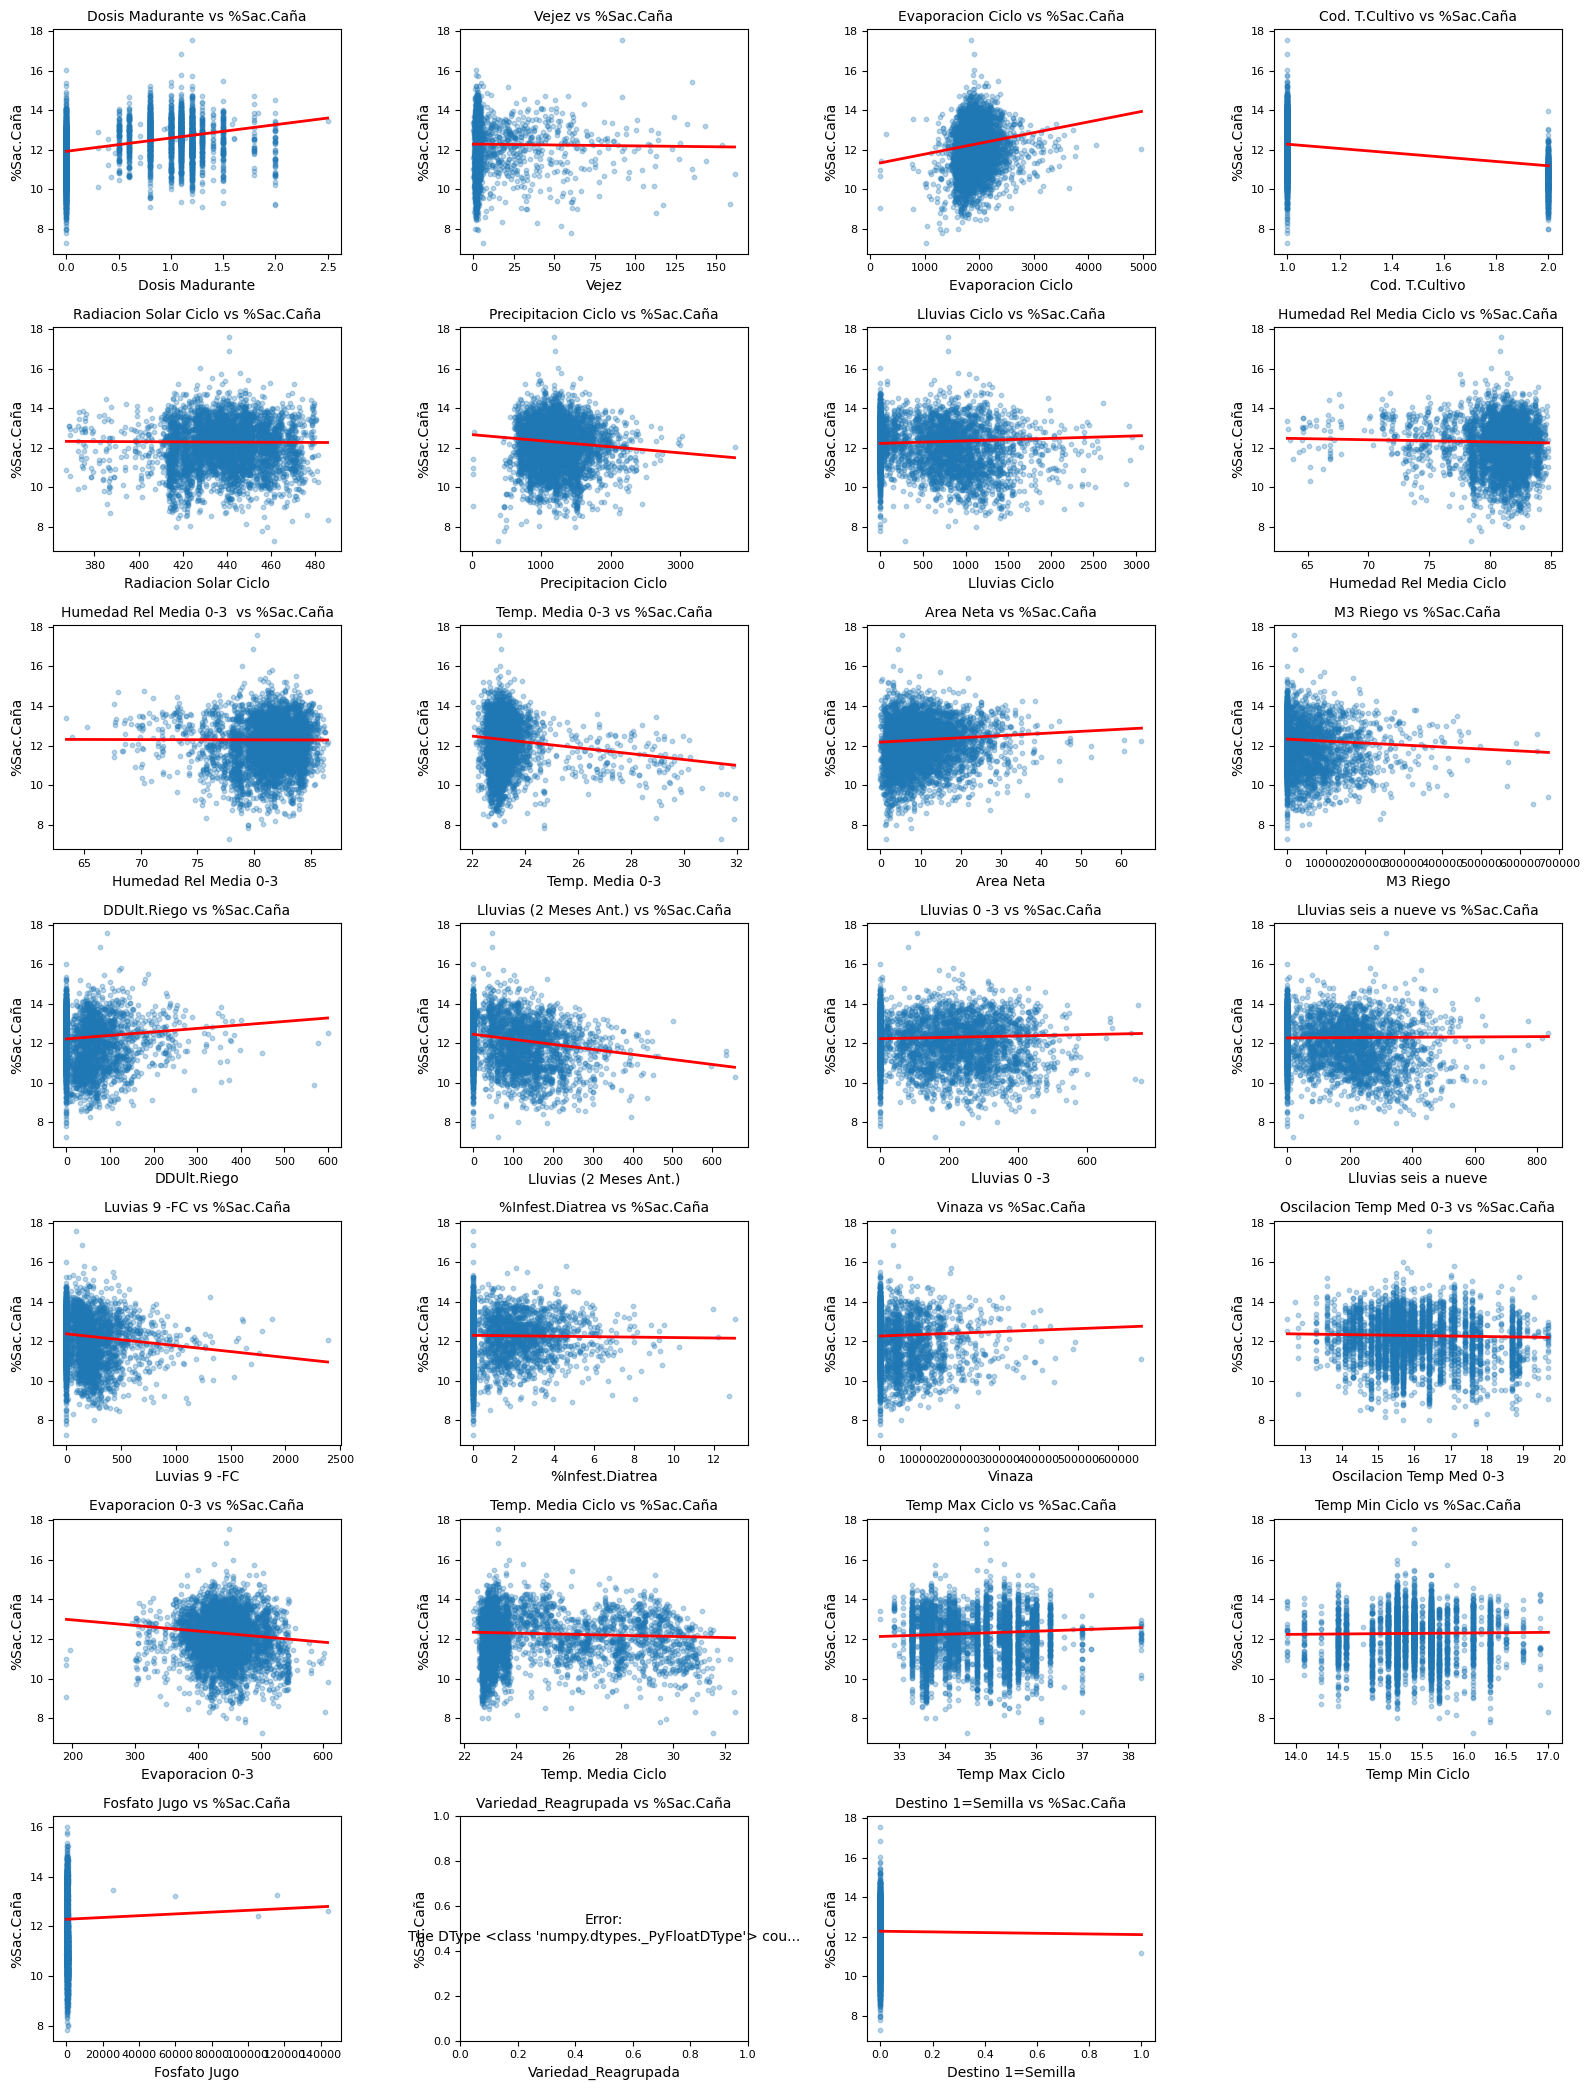

In [37]:
def plot_all_variables_vs_target(X_train, y_train, df_mod, target_col, model, preprocessor, 
                                figsize_per_plot=(4, 3)):
    
    variables = X_train.columns
    n_vars = len(variables)
    n_cols = 4
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, 
                            figsize=(figsize_per_plot[0] * n_cols, 
                                   figsize_per_plot[1] * n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    axes_flat = axes.flatten()

    base_values = {}
    for col in X_train.columns:
        if X_train[col].dtype in ['object', 'string'] or X_train[col].nunique() < 10:
            base_values[col] = X_train[col].mode()[0]
        else:
            base_values[col] = X_train[col].mean()
    
    for i, var in enumerate(variables):
        ax = axes_flat[i]
        
        try:
            X_range = np.linspace(df_mod[var].min(), df_mod[var].max(), 100)
            
            X_plot = pd.DataFrame([base_values] * 100)
            X_plot[var] = X_range
            
            X_plot_prep = preprocessor.transform(X_plot)
            y_pred = model.predict(X_plot_prep)
            
            ax.scatter(df_mod[var], df_mod[target_col], alpha=0.3, s=10)
            ax.plot(X_range, y_pred, color="red", linewidth=2)
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error:\n{str(e)[:50]}...', 
                   transform=ax.transAxes, ha='center', va='center')
        
        ax.set_xlabel(var)
        ax.set_ylabel(target_col)
        ax.set_title(f'{var} vs {target_col}', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)

    for i in range(n_vars, len(axes_flat)):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_all_variables_vs_target(
    X_train=X_train,
    y_train=y_train, 
    df_mod=df_mod,
    target_col='%Sac.Caña',
    model=grid_search_ridge.best_estimator_,
    preprocessor=preprocessor
)

In [38]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include='object').columns.tolist()


numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),   
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)


cv_scores_lr_mse = -cross_val_score(
    LinearRegression(),
    X_train_prep, y_train,
    cv=5,
    scoring='neg_mean_squared_error'
)

cv_scores_lr_r2 = cross_val_score(
    LinearRegression(),
    X_train_prep, y_train,
    cv=5,
    scoring='r2'
)
cv_scores_lr_rmse = np.sqrt(cv_scores_lr_mse)

lr_model = LinearRegression().fit(X_train_prep, y_train)
y_pred_lr = lr_model.predict(X_test_prep)

print("\n--- Regresión Polinómica (Lineal) ---")
print(f"MSE promedio (CV): {np.mean(cv_scores_lr_mse):.4f} (+/- {np.std(cv_scores_lr_mse):.4f})")
print(f"RMSE promedio (CV): {np.mean(cv_scores_lr_rmse):.4f} (+/- {np.std(cv_scores_lr_rmse):.4f})")
print(f"R^2 promedio (CV): {np.mean(cv_scores_lr_r2):.4f} (+/- {np.std(cv_scores_lr_r2):.4f})")
print(f"Train R²: {lr_model.score(X_train_prep, y_train):.4f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_lr):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_lr):.4f}")

param_grid = {'alpha': np.logspace(-4, 2, 100)}  

grid_search_ridge = GridSearchCV(
    Ridge(),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_ridge.fit(X_train_prep, y_train)

ridge_best = grid_search_ridge.best_estimator_
y_pred_ridge = ridge_best.predict(X_test_prep)

print("\n--- Ridge (L2) ---")
print(f"Mejor alpha: {grid_search_ridge.best_params_['alpha']:.4f}")
print(f"Mejor MSE (CV): {-grid_search_ridge.best_score_:.4f}")
print(f"Mejor RMSE (CV): {np.sqrt(-grid_search_ridge.best_score_):.4f}")
print(f"Train R²: {ridge_best.score(X_train_prep, y_train):.4f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_ridge):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_ridge):.4f}")

grid_search_lasso = GridSearchCV(
    Lasso(),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_search_lasso.fit(X_train_prep, y_train)

lasso_best = grid_search_lasso.best_estimator_
y_pred_lasso = lasso_best.predict(X_test_prep)

print("\n--- Lasso (L1) ---")
print(f"Mejor alpha: {grid_search_lasso.best_params_['alpha']:.4f}")
print(f"Mejor MSE (CV): {-grid_search_lasso.best_score_:.4f}")
print(f"Mejor RMSE (CV): {np.sqrt(-grid_search_lasso.best_score_):.4f}")
print(f"Train R²: {lasso_best.score(X_train_prep, y_train):.4f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_lasso):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_lasso)):.4f}")
print(f"Test R²: {r2_score(y_test, y_pred_lasso):.4f}")


--- Regresión Polinómica (Lineal) ---
MSE promedio (CV): 22.5475 (+/- 34.2462)
RMSE promedio (CV): 3.5267 (+/- 3.1797)
R^2 promedio (CV): -16.7723 (+/- 27.9243)
Train R²: 0.5741
Test MSE: 0.7064
Test RMSE: 0.8405
Test R²: 0.5185

--- Ridge (L2) ---
Mejor alpha: 100.0000
Mejor MSE (CV): 1.0960
Mejor RMSE (CV): 1.0469
Train R²: 0.5490
Test MSE: 0.6861
Test RMSE: 0.8283
Test R²: 0.5323

--- Lasso (L1) ---
Mejor alpha: 0.0076
Mejor MSE (CV): 0.7570
Mejor RMSE (CV): 0.8700
Train R²: 0.5154
Test MSE: 0.7158
Test RMSE: 0.8460
Test R²: 0.5121


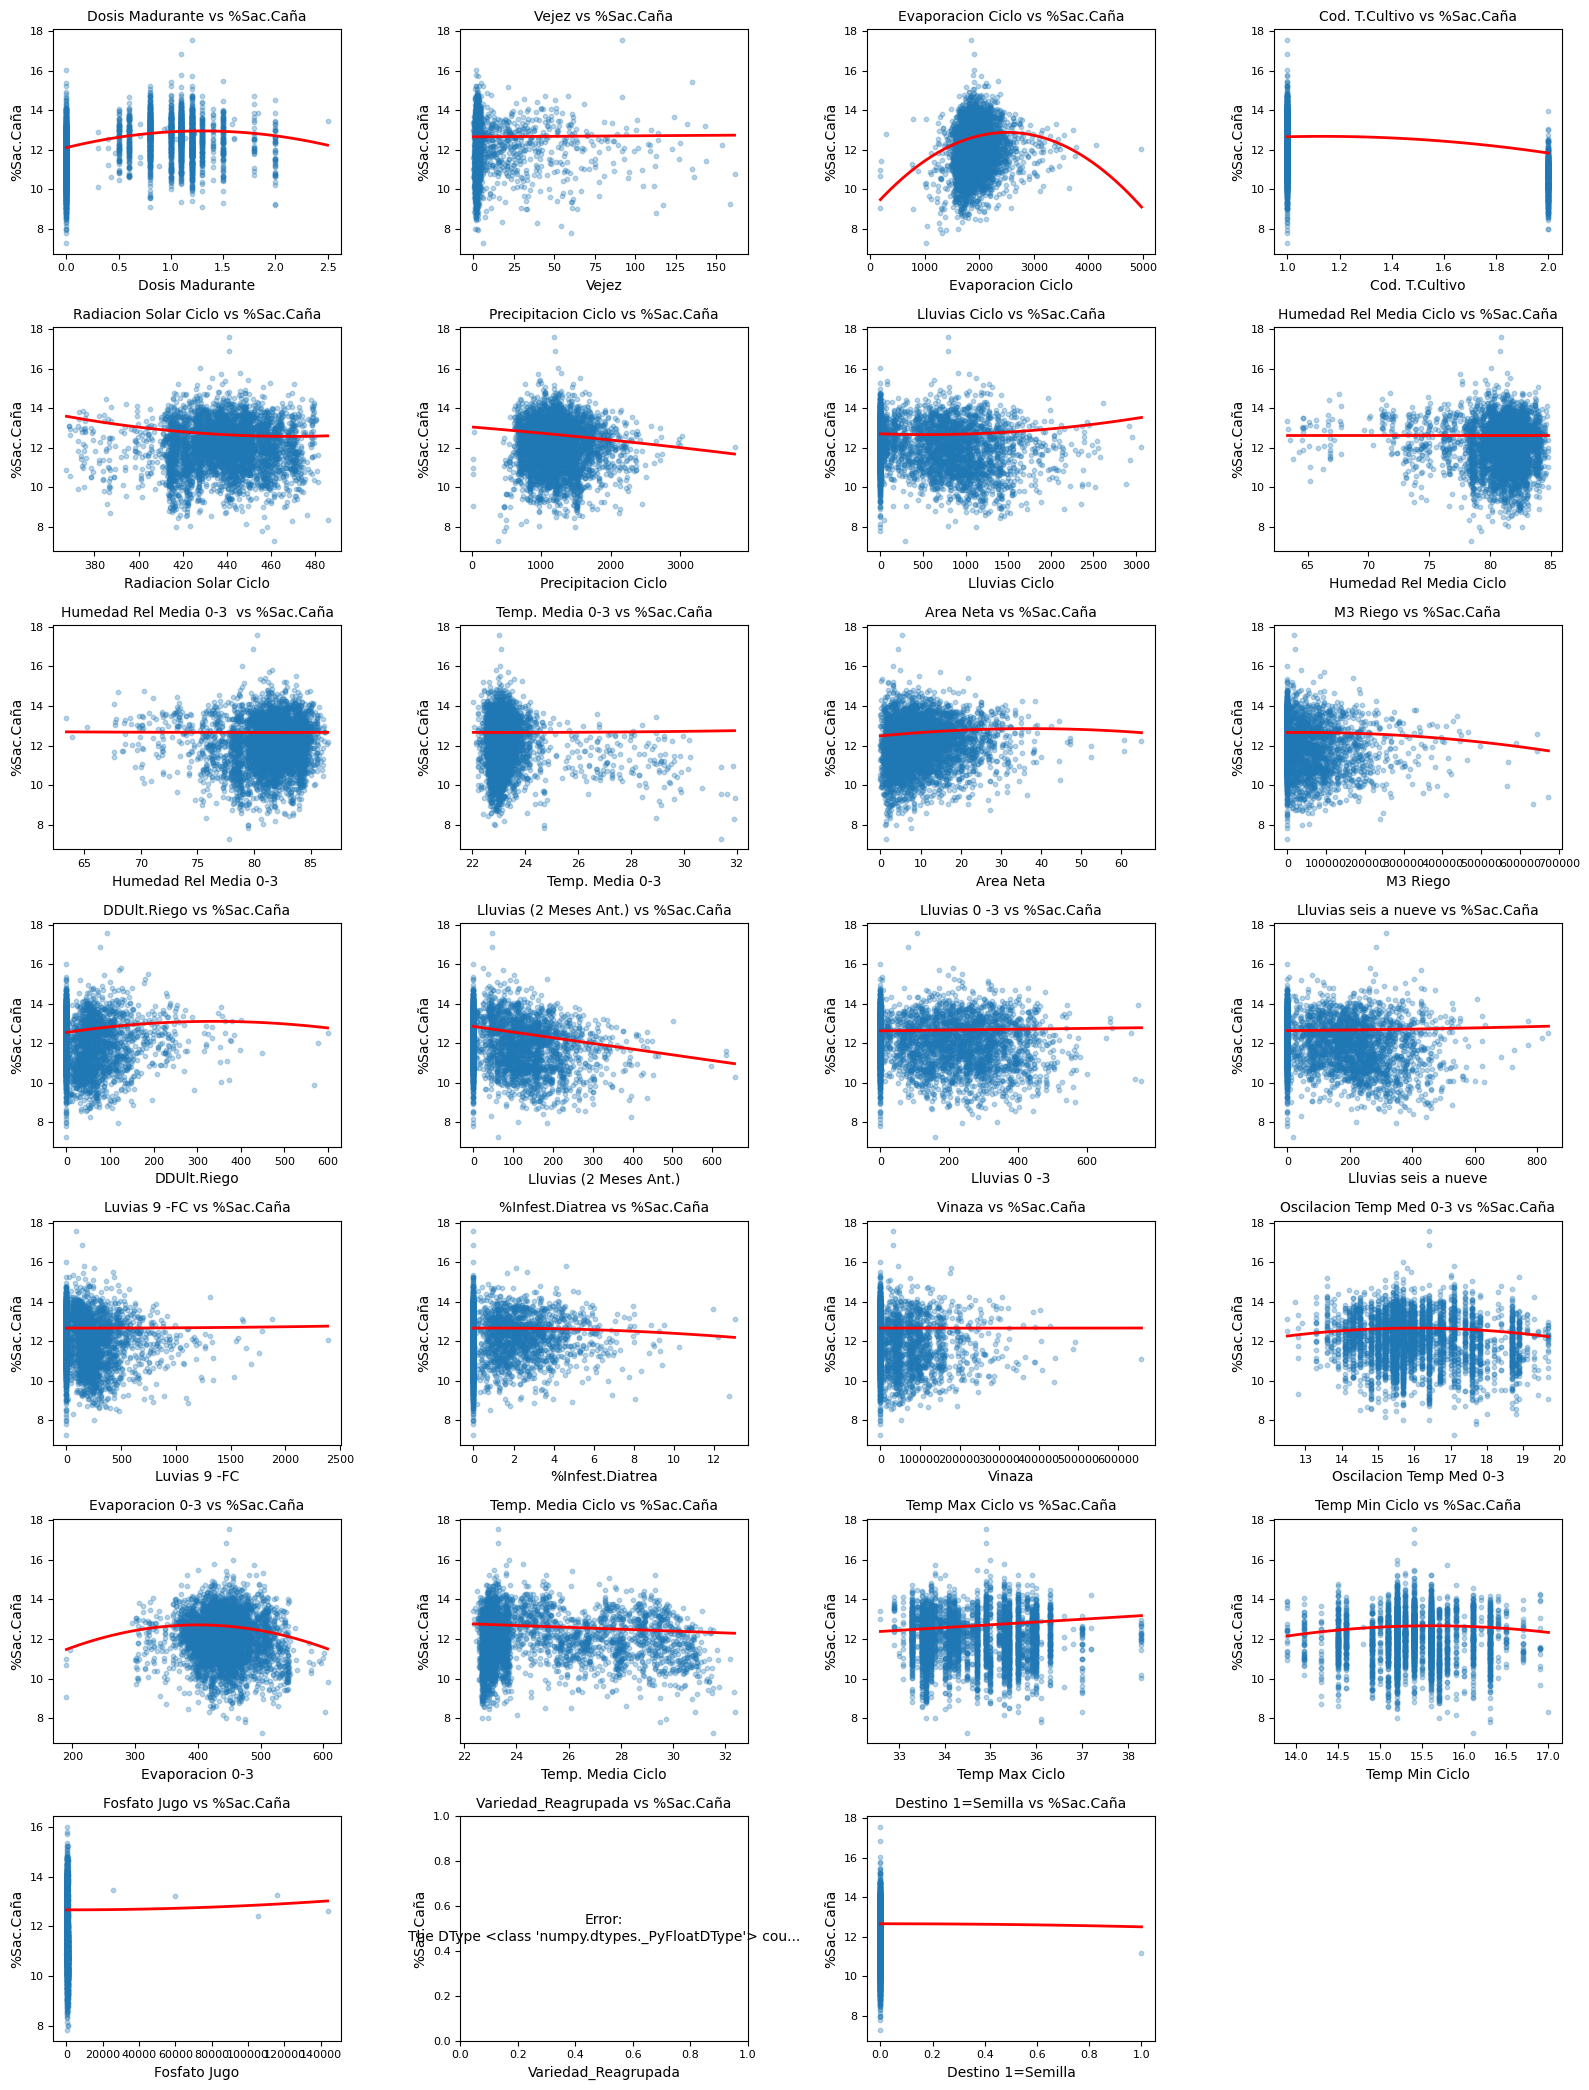

In [39]:
def plot_all_variables_vs_target(X_train, y_train, df_mod, target_col, model, preprocessor, 
                                figsize_per_plot=(4, 3)):
    
    variables = X_train.columns
    n_vars = len(variables)
    n_cols = 4
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, 
                            figsize=(figsize_per_plot[0] * n_cols, 
                                   figsize_per_plot[1] * n_rows))
    
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    axes_flat = axes.flatten()

    base_values = {}
    for col in X_train.columns:
        if X_train[col].dtype in ['object', 'string'] or X_train[col].nunique() < 10:
            base_values[col] = X_train[col].mode()[0]
        else:
            base_values[col] = X_train[col].mean()
    
    for i, var in enumerate(variables):
        ax = axes_flat[i]
        
        try:
            X_range = np.linspace(df_mod[var].min(), df_mod[var].max(), 100)
            
            X_plot = pd.DataFrame([base_values] * 100)
            X_plot[var] = X_range
            
            X_plot_prep = preprocessor.transform(X_plot)
            y_pred = model.predict(X_plot_prep)
            
            ax.scatter(df_mod[var], df_mod[target_col], alpha=0.3, s=10)
            ax.plot(X_range, y_pred, color="red", linewidth=2)
            
        except Exception as e:
            ax.text(0.5, 0.5, f'Error:\n{str(e)[:50]}...', 
                   transform=ax.transAxes, ha='center', va='center')
        
        ax.set_xlabel(var)
        ax.set_ylabel(target_col)
        ax.set_title(f'{var} vs {target_col}', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)

    for i in range(n_vars, len(axes_flat)):
        axes_flat[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

plot_all_variables_vs_target(
    X_train=X_train,
    y_train=y_train, 
    df_mod=df_mod,
    target_col='%Sac.Caña',
    model=grid_search_lasso.best_estimator_,
    preprocessor=preprocessor
)